In [1]:
import pandas as pd
import numpy as np
import sys
import os

import plotly.graph_objects as go
from plotly.subplots import make_subplots


sys.path.append(os.path.abspath(".."))
from core.viz import plot_line, create_subplot_grid, plot_bar, plot_statistical_strip
from core.s3 import S3AssetManager

In [2]:
notebook_name = "cervalle_production"
s3 = S3AssetManager(notebook_name=notebook_name)


PALETA_CORPORATIVA = [
    "#1C8074",  # PANTONE 3295 U
    "#666666",  # PANTONE 426 U
    "#1A494C",  # PANTONE 175-16 U
    "#94AF92",  # PANTONE 7494 U
    "#E6ECD8",  # PANTONE 152-2 U
    "#C9C9C9"   # PANTONE COLOR GRAY 2 U
]

In [3]:
def plot_metric_scatter_by_plotly(df, metric, hue_col="PELET", palette=None):
    """
    Crea un scatterplot interactivo con Plotly de la media y desviación estándar de una métrica por fecha y categoría.

    Parámetros:
        df : DataFrame con columnas 'FECHA', '{metric}_mean', '{metric}_std' y la columna categórica (e.g. PELET).
        metric : str, nombre base de la métrica (ej. 'DURABILIDAD').
        hue_col : str, nombre de la columna para color (e.g. PELET).
        palette : dict opcional de colores personalizados por grupo.
        html_path : str, ruta para guardar el HTML interactivo.
    """

    fig = make_subplots(rows=1, cols=2, shared_xaxes=True,
                        subplot_titles=(f"{metric} - Media", f"{metric} - Desviación estándar"))

    unique_groups = df[hue_col].dropna().unique()

    for group in unique_groups:
        group_df = df[df[hue_col] == group]

        color = palette[group] if palette and group in palette else None

        # Plot mean
        fig.add_trace(go.Scatter(
            x=group_df["FECHA"],
            y=group_df[f"{metric}_mean"],
            mode="markers+lines",
            name=str(group),
            marker=dict(color=color),
            legendgroup=str(group),
            showlegend=True
        ), row=1, col=1)

        # Plot std
        fig.add_trace(go.Scatter(
            x=group_df["FECHA"],
            y=group_df[f"{metric}_std"],
            mode="markers+lines",
            name=str(group),
            marker=dict(color=color),
            legendgroup=str(group),
            showlegend=False  # Solo en la izquierda
        ), row=1, col=2)

    fig.update_layout(
        title_text=f"Evolución temporal de {metric}",
        height=500,
        width=1100,
        legend_title=hue_col,
        margin=dict(t=80),
        plot_bgcolor="white",   # Fondo del área de gráfica
        paper_bgcolor="white",  # Fondo exterior (lienzo)
        font=dict(color="black")  # Colores de texto en general
    )

    fig.update_xaxes(title_text="Fecha", tickangle=45, row=1, col=1, color="black")
    fig.update_xaxes(title_text="Fecha", tickangle=45, row=1, col=2, color="black")
    fig.update_yaxes(title_text="Valor medio", row=1, col=1, color="black")
    fig.update_yaxes(title_text="Desviación", row=1, col=2, color="black")

   

    return fig




def plot_metric_scatter_by_plotly_with_trend(
    df, metric, hue_col="PELET", palette=None,
    background="white"
):
    """
    Crea gráfico de dispersión en Plotly con línea de tendencia roja por fecha.

    Parámetros:
        df : DataFrame con columnas 'FECHA', '{metric}_mean', '{metric}_std' y columna de categoría (e.g. PELET).
        metric : str, nombre de la métrica (ej. 'Tª').
        hue_col : str, columna categórica para color (ej. 'PELET').
        palette : dict opcional de colores por grupo.
        html_path : str, ruta para guardar el HTML.
        background : "white" o "transparent"
    """
    df = df.sort_values("FECHA")
    fig = make_subplots(rows=1, cols=2, shared_xaxes=True,
                        subplot_titles=(f"{metric} - Media", f"{metric} - Desviación estándar"))

    unique_groups = df[hue_col].dropna().unique()

    for group in unique_groups:
        group_df = df[df[hue_col] == group]
        color = palette[group] if palette and group in palette else None

        # MÉDIA
        fig.add_trace(go.Scatter(
            x=group_df["FECHA"],
            y=group_df[f"{metric}_mean"],
            mode="markers+lines",
            name=f"{group}",
            marker=dict(color=color),
            legendgroup=str(group),
            showlegend=True
        ), row=1, col=1)

        # STD
        fig.add_trace(go.Scatter(
            x=group_df["FECHA"],
            y=group_df[f"{metric}_std"],
            mode="markers+lines",
            name=f"{group}",
            marker=dict(color=color),
            legendgroup=str(group),
            showlegend=False
        ), row=1, col=2)

    df_pelet2 = df[df[hue_col] == 2]
    trend_mean = df_pelet2.groupby("FECHA")[f"{metric}_mean"].mean().rolling(10, min_periods=1).mean()
    fig.add_trace(go.Scatter(
        x=trend_mean.index,
        y=trend_mean.values,
        mode="lines",
        name="Tendencia media PELET 2",
        line=dict(color="red", width=5, dash="dot"),
        showlegend=True
    ), row=1, col=1)

    bg_color = "white" if background == "white" else "rgba(0,0,0,0)"  # para fondo transparente

    fig.update_layout(
        title_text=f"Evolución temporal de {metric}",
        height=500,
        width=1100,
        legend_title=hue_col,
        margin=dict(t=80),
        plot_bgcolor=bg_color,
        paper_bgcolor=bg_color,
        font=dict(color="black")
    )

    fig.update_xaxes(title_text="Fecha", tickangle=45, row=1, col=1, color="black")
    fig.update_xaxes(title_text="Fecha", tickangle=45, row=1, col=2, color="black")
    fig.update_yaxes(title_text="Valor medio", row=1, col=1, color="black")
    fig.update_yaxes(title_text="Desviación", row=1, col=2, color="black")

    return fig




def plot_distributions(df, columns, group_col="PELET", palette=None):
    """
    Plotea la distribución (KDE) de columnas dadas segmentadas por grupo, con línea de media por grupo.

    Parámetros:
        df: DataFrame con datos.
        columns: Lista de columnas numéricas a graficar (e.g. ["Tª", "Tª ACONDICI", "Tª ENFR"]).
        group_col: Columna para hue (e.g. 'PELET').
        palette: Diccionario o lista de colores para cada grupo.
    """
    for col in columns:
        plt.figure(figsize=(10, 5))
        for i, grupo in enumerate(df[group_col].dropna().unique()):
            data_ = df[df[group_col] == grupo][col].dropna()
            color = palette[grupo] if isinstance(palette, dict) else palette[i % len(palette)]

            # KDE plot
            sns.kdeplot(data_, label=f"{grupo}", color=color, linewidth=2)

            # Línea y texto de media
            media = data_.mean()
            plt.axvline(media, color=color, linestyle="--", linewidth=1.5)
            plt.text(media, plt.ylim()[1]*0.9, f"{media:.2f}", color=color, rotation=0,
                     ha="right", va="center", fontsize=10, bbox=dict(facecolor='white', alpha=0.1, edgecolor=color))

        plt.title(f"Distribución de {col} por {group_col}")
        plt.xlabel(col)
        plt.ylabel("Densidad")
        plt.legend(title=group_col)
        plt.tight_layout()
        plt.show()




def plot_distributions_plotly(df, columns, group_col="PELET", palette=None, bandwidth_adjust=1.0, html_path=None):
    """
    Grafica distribuciones KDE por grupo con línea y valor de media usando Plotly.

    Parámetros:
        df : DataFrame con los datos.
        columns : Lista de columnas numéricas a graficar.
        group_col : Columna para separar por categoría (e.g. PELET).
        palette : Diccionario o lista de colores por grupo.
        bandwidth_adjust : Factor para ajustar suavizado de KDE (por defecto 1.0).
        html_path : str opcional, ruta para guardar como HTML.
    """
    for col in columns:
        fig = go.Figure()
        ymax = 0

        for i, group in enumerate(df[group_col].dropna().unique()):
            data_ = df[df[group_col] == group][col].dropna()
            if len(data_) < 2:
                continue  # evitar errores con KDE

            color = palette[group] if isinstance(palette, dict) else None

            # KDE con scipy
            kde = gaussian_kde(data_, bw_method=bandwidth_adjust)
            x_range = np.linspace(data_.min(), data_.max(), 200)
            y_kde = kde(x_range)

            # Actualizar el máximo para escalar el texto
            ymax = max(ymax, max(y_kde))

            # Línea de KDE
            fig.add_trace(go.Scatter(
                x=x_range,
                y=y_kde,
                mode='lines',
                name=f"{group}",
                line=dict(color=color),
                hoverinfo='skip',
            ))

            # Línea de la media
            media = data_.mean()
            fig.add_trace(go.Scatter(
                x=[media, media],
                y=[0, max(y_kde)],
                mode='lines',
                line=dict(color=color, dash='dash'),
                showlegend=False
            ))

            # Texto del valor medio
            fig.add_trace(go.Scatter(
                x=[media],
                y=[max(y_kde) * 0.95],
                text=[f"{media:.2f}"],
                mode="text",
                showlegend=False,
                textposition="top center"
            ))

        fig.update_layout(
            title=f"Distribución de {col} por {group_col}",
            xaxis_title=col,
            yaxis_title="Densidad",
            height=400,
            width=800,
            legend_title=group_col
        )

        if html_path:
            fig.write_html(html_path.replace(".html", f"_{col}.html"))

        fig.show()



def plot_metric_scatter_by_pelet(df, metric, hue_col="PELET", palette=None, figsize=(14, 5)):
    """
    Grafica dos scatterplots (mean y std) en subplots 1x2 para una métrica dada por fecha y categoría (hue).

    Parámetros:
        df : DataFrame con columnas tipo 'FECHA', '{metric}_mean', '{metric}_std' y columna hue (e.g. PELET).
        metric : str, nombre base de la métrica (ej. 'DURABILIDAD').
        hue_col : str, nombre de la columna de categoría.
        palette : dict, lista o dict de colores para el hue.
        figsize : tuple, tamaño de la figura.
    """

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    # Plot mean
    sns.scatterplot(
        data=df,
        x="FECHA",
        y=f"{metric}_mean",
        hue=hue_col,
        palette=palette,
        ax=axes[0]
    )
    axes[0].set_title(f"{metric} - Media")
    axes[0].set_xlabel("Fecha")
    axes[0].set_ylabel("Valor medio")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot std
    sns.scatterplot(
        data=df,
        x="FECHA",
        y=f"{metric}_std",
        hue=hue_col,
        palette=palette,
        ax=axes[1],
        legend=False  # Solo una leyenda
    )
    axes[1].set_title(f"{metric} - Desviación estándar")
    axes[1].set_xlabel("Fecha")
    axes[1].set_ylabel("Desviación")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle(f"Evolución temporal de {metric}", y=1.05)
    plt.show()

In [4]:
#process_pel = pd.read_excel("data_cervalle/SEGUIMIENTO PROCESO PELETIZADO (1).xlsm")
process_pel =  s3.read_excel(
    "raw/cervalle/SEGUIMIENTO PROCESO PELETIZADO (1).xlsm",
    sheet_name='SEGUIMIENTO PELETIZADORAS',
)

process_pel.columns = [cols.strip() for cols in process_pel.columns]

process_pel = process_pel[process_pel["FECHA"].notnull()]
process_pel["FECHA"] = pd.to_datetime(process_pel["FECHA"])
process_pel["month"] = process_pel["FECHA"].dt.month

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_91754/1116077680.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  process_pel["FECHA"] = pd.to_datetime(process_pel["FECHA"])


In [5]:

process_pel["FECHA"].max(), process_pel["FECHA"].min()

(Timestamp('2026-05-24 00:00:00'), Timestamp('2024-01-02 00:00:00'))

In [6]:
process_pel["month"].value_counts()

1     458
5     401
4     397
6     377
7     371
3     349
2     323
9       2
10      1
12      1
Name: month, dtype: int64

In [7]:
process_pel["MES"].value_counts()

1.0     459
4.0     397
5.0     392
6.0     382
7.0     372
3.0     349
2.0     326
8.0       2
56.0      1
Name: MES, dtype: int64

In [8]:
process_pel["LOTE"].duplicated().sum()

1638

In [9]:
col_ref = ["LOTE", "PELET", "CODIGO", "TURNO", "FECHA"] #
process_pel[process_pel.duplicated(subset=col_ref, keep=False)].sort_values(by=col_ref)

Unnamed: 0      FECHA  MES    LOTE   CODIGO            PRODUCTO  TURNO  \
2669         NaN 2024-01-02  1.0  1703.0  703-298  CEBA FINALIZACION     2.0   
2670         NaN 2024-01-02  1.0  1703.0  703-298  CEBA FINALIZACION     2.0   
2677         NaN 2024-01-02  1.0  1705.0  610-596         PRELEVANTE     1.0   
2679         NaN 2024-01-02  1.0  1705.0  610-596         PRELEVANTE     1.0   
2676         NaN 2024-01-02  1.0  1705.0  610-596         PRELEVANTE     1.0   
...          ...        ...  ...     ...      ...                 ...    ...   
14           NaN 2025-07-24  7.0  2863.0  703-298  CEBA FINALIZACION     2.0   
7            NaN 2025-07-24  7.0  2865.0  920-597   HEMBRAS REEMPLAZO    3.0   
9            NaN 2025-07-24  7.0  2865.0  920-597   HEMBRAS REEMPLAZO    3.0   
6            NaN 2025-07-24  7.0  2865.0  920-597   HEMBRAS REEMPLAZO    3.0   
8            NaN 2025-07-24  7.0  2865.0  920-597   HEMBRAS REEMPLAZO    3.0   

      PELET  DURABILIDAD  FINOS  ...  HUME ENFRI  AGUA  T° AMB  HUMEDAD AMB  \
2669    1.0         99.7    0.3  ...       12.24   NaN    31.8         45.0   
2670    1.0         99.6    0.4  ...       11.82   NaN    33.4         47.0   
2677    1.0         99.6    0.4  ...       11.99   NaN    28.0         68.0   
2679    1.0         99.1    0.9  ...       13.38   NaN    26.0         68.0   
2676    2.0         96.1    3.9  ...       11.07   NaN    25.5         72.0   
...     ...          ...    ...  ...         ...   ...     ...          ...   
14      1.0         99.8    0.2  ...       11.70   0.0    36.0         39.0   
7       1.0         99.8    0.2  ...       12.44   NaN    30.0         45.0   
9       1.0         99.7    0.3  ...       11.98   NaN    31.0         43.0   
6       2.0         99.4    0.6  ...       11.29   NaN    27.4         32.0   
8       2.0         99.6    0.4  ...       11.04   NaN    28.3         49.0   

        OBSERVACIONES  # DADO      HORA  Unnamed: 23  Unnamed: 24  month  
2669        AMP 101.5    M 4   19:10:00          NaN          NaN      1  
2670          AMP 103    M 4   17:30:00          NaN          NaN      1  
2677        AMP 103.7     M 4  10:00:00          NaN          NaN      1  
2679        AMP 99.25     M 4  08:00:00          NaN          NaN      1  
2676          AMP 105   MT 07  10:30:00          NaN          NaN      1  
...               ...     ...       ...          ...          ...    ...  
14             AMP 77    M 4   14:15:00          NaN          NaN      7  
7           AMP 80.90     M 4  12:00:00          NaN          NaN      7  
9           AMP 80.60     M 4  10:00:00          NaN          NaN      7  
6     AMP 106.9-119.6   MT 07  12:45:00          NaN          NaN      7  
8     AMP 100.2-116.3   MT 07  10:30:00          NaN          NaN      7  

[1035 rows x 26 columns]

## Análisis en variables de calidad (promedio-variabilidad) por día y peletizadora

In [10]:
# TODO:Evolución del las métricas en el tiempo

cols_metric = [
    'DURABILIDAD', 'FINOS', 'PRESION', 'Tª', 'carga',
    'Tª ACONDICI', 'Tª ENFR', 'HUME ACONDIC', 'HUME ENFRI', 'T° AMB', 'HUMEDAD AMB'
]
by_date_stats_pel = process_pel.groupby(["FECHA", "PELET"])[cols_metric].agg(['mean', 'std'])
by_date_stats_pel.columns = [f"{col}_{stat}" for col, stat in by_date_stats_pel.columns]
by_date_stats_pel = by_date_stats_pel.reset_index()


pel_unicos = by_date_stats_pel["PELET"].unique()
palette_pel = dict(zip(pel_unicos, PALETA_CORPORATIVA))



# TODO: Filtra periodo real de trabajo
by_date_stats_pel = by_date_stats_pel[
    by_date_stats_pel["FECHA"].between("2025-01-01", "2025-07-01")
]

by_date_stats_pel

FECHA  PELET  DURABILIDAD_mean  DURABILIDAD_std  FINOS_mean  \
11  2025-01-02    1.0         99.600000              NaN    0.400000   
12  2025-01-02    2.0         98.100000              NaN    1.900000   
13  2025-01-03    1.0         98.566667         2.849561    1.433333   
14  2025-01-03    2.0         96.322222         1.481366    3.677778   
15  2025-01-04    1.0         99.300000         0.624500    0.700000   
..         ...    ...               ...              ...         ...   
308 2025-06-28    2.0         97.962500         1.939763    2.037500   
309 2025-06-29    1.0         99.400000         0.316228    0.600000   
310 2025-06-29    2.0         98.328571         1.056274    1.671429   
311 2025-07-01    1.0         99.380000         0.248998    0.620000   
312 2025-07-01    2.0         98.266667         1.003328    1.733333   

     FINOS_std  PRESION_mean  PRESION_std    Tª_mean    Tª_std  ...  \
11         NaN     19.000000          NaN  80.000000       NaN  ...   
12         NaN     20.000000          NaN  78.000000       NaN  ...   
13    2.849561     18.777778     1.301708  74.711111  3.626446  ...   
14    1.481366     20.444444     1.333333  79.000000  1.322876  ...   
15    0.624500     19.000000     0.000000  76.000000  1.870829  ...   
..         ...           ...          ...        ...       ...  ...   
308   1.939763     19.500000     0.925820  77.625000  5.629958  ...   
309   0.316228     18.000000     0.000000  78.485714  3.490668  ...   
310   1.056274     18.857143     1.069045  80.857143  3.387653  ...   
311   0.248998     18.000000     0.000000  76.480000  3.336465  ...   
312   1.003328     19.666667     0.816497  78.000000  6.418723  ...   

     Tª ENFR_mean  Tª ENFR_std  HUME ACONDIC_mean  HUME ACONDIC_std  \
11      27.800000          NaN          13.850000               NaN   
12      27.700000          NaN          13.940000               NaN   
13      28.900000     2.113646          14.262222          0.752774   
14      29.566667     2.430021          13.932222          0.483962   
15      28.620000     1.715226          14.614000          0.613865   
..            ...          ...                ...               ...   
308     31.212500     1.889397          12.983750          0.860813   
309     30.914286     2.060282          13.645714          0.598411   
310     30.700000     1.833030          13.070000          0.392131   
311     30.300000     2.284732          14.092000          0.255186   
312     30.350000     1.730607          13.395000          0.554572   

     HUME ENFRI_mean  HUME ENFRI_std  T° AMB_mean  T° AMB_std  \
11         12.710000             NaN    27.700000         NaN   
12         12.310000             NaN    25.200000         NaN   
13         12.504444        0.716277    28.088889    2.621757   
14         11.982000        0.629719    25.022222    2.880442   
15         12.688000        0.343103    29.100000    1.521512   
..               ...             ...          ...         ...   
308        11.011250        0.333228    28.887500    3.059149   
309        12.174286        0.459596    30.142857    2.478479   
310        11.440000        0.525991    28.428571    2.149197   
311        12.068000        0.241392    30.900000    2.607681   
312        11.696667        0.419698    28.000000    2.366432   

     HUMEDAD AMB_mean  HUMEDAD AMB_std  
11          56.000000              NaN  
12          65.000000              NaN  
13          56.222222         3.898005  
14          65.666667         6.837397  
15          53.800000         5.932959  
..                ...              ...  
308         56.500000         7.111359  
309         49.714286         3.638419  
310         55.285714         3.903600  
311         51.400000         5.504544  
312         58.166667         6.645801  

[302 rows x 24 columns]

In [11]:
f = plot_metric_scatter_by_plotly(
    df=by_date_stats_pel,
    metric="DURABILIDAD",
    hue_col="PELET",
    palette=palette_pel,
    #html_path=f"{ROOT_IMAGEN}/durabilidad_pelet.html"
)
f.show()
s3.save_plotly_html(f, "durabilidad_pelet.html")


In [12]:
f = plot_metric_scatter_by_plotly(
    df=by_date_stats_pel,
    metric="FINOS",
    hue_col="PELET",
    palette=palette_pel,
    #html_path=f"{ROOT_IMAGEN}/finos_pelet.html"
)
f.show()
s3.save_plotly_html(f, "finos_pelet.html")

In [13]:
f = plot_metric_scatter_by_plotly(
    df=by_date_stats_pel,
    metric="Tª ACONDICI",
    hue_col="PELET",
    palette=palette_pel,
)
f.show()
s3.save_plotly_html(f, "temp_acond_pelet.html")


In [14]:
f = plot_metric_scatter_by_plotly_with_trend(
    df=by_date_stats_pel, metric="Tª",hue_col="PELET",
    palette=palette_pel)
f.show()
s3.save_plotly_html(f, "temp_acond_pelet_tiempo.html")

## Análisis en variables de calidad (promedio-variabilidad) por día y peletizadora


In [15]:
top_prod = pd.DataFrame(process_pel["PRODUCTO"].value_counts()).reset_index()["PRODUCTO"].head(5)
process_pel_ppal_prod = process_pel[process_pel["PRODUCTO"].isin(top_prod)]
by_date_product_stats = process_pel_ppal_prod.groupby(["FECHA", "PRODUCTO"])[cols_metric].agg(['mean', 'std'])
by_date_product_stats.columns = [f"{col}_{stat}" for col, stat in by_date_product_stats.columns]
by_date_product_stats = by_date_product_stats.reset_index()

pel_unicos = by_date_product_stats["PRODUCTO"].unique()
palette_product = dict(zip(pel_unicos, PALETA_CORPORATIVA))
# TODO: Filtra periodo real de trabajo
by_date_product_stats = by_date_product_stats[
    by_date_product_stats["FECHA"].between("2025-01-01", "2025-07-01")
]
by_date_product_stats

Empty DataFrame
Columns: [FECHA, PRODUCTO, DURABILIDAD_mean, DURABILIDAD_std, FINOS_mean, FINOS_std, PRESION_mean, PRESION_std, Tª_mean, Tª_std, carga_mean, carga_std, Tª ACONDICI_mean, Tª ACONDICI_std, Tª ENFR_mean, Tª ENFR_std, HUME ACONDIC_mean, HUME ACONDIC_std, HUME ENFRI_mean, HUME ENFRI_std, T° AMB_mean, T° AMB_std, HUMEDAD AMB_mean, HUMEDAD AMB_std]
Index: []

[0 rows x 24 columns]

In [16]:
f = plot_metric_scatter_by_plotly(
    df=by_date_product_stats,
    metric="DURABILIDAD",
    hue_col="PRODUCTO",
    palette=palette_product,
    )
f.show()
s3.save_plotly_html(f, "durabilidad_producto.html")

In [17]:
plot_metric_scatter_by_plotly(
    df=by_date_product_stats,
    metric="Tª",
    hue_col="PRODUCTO",
    palette=palette_product,)

## Relacción por día de trabajo de las metricas medibles del proceso por peletizadora

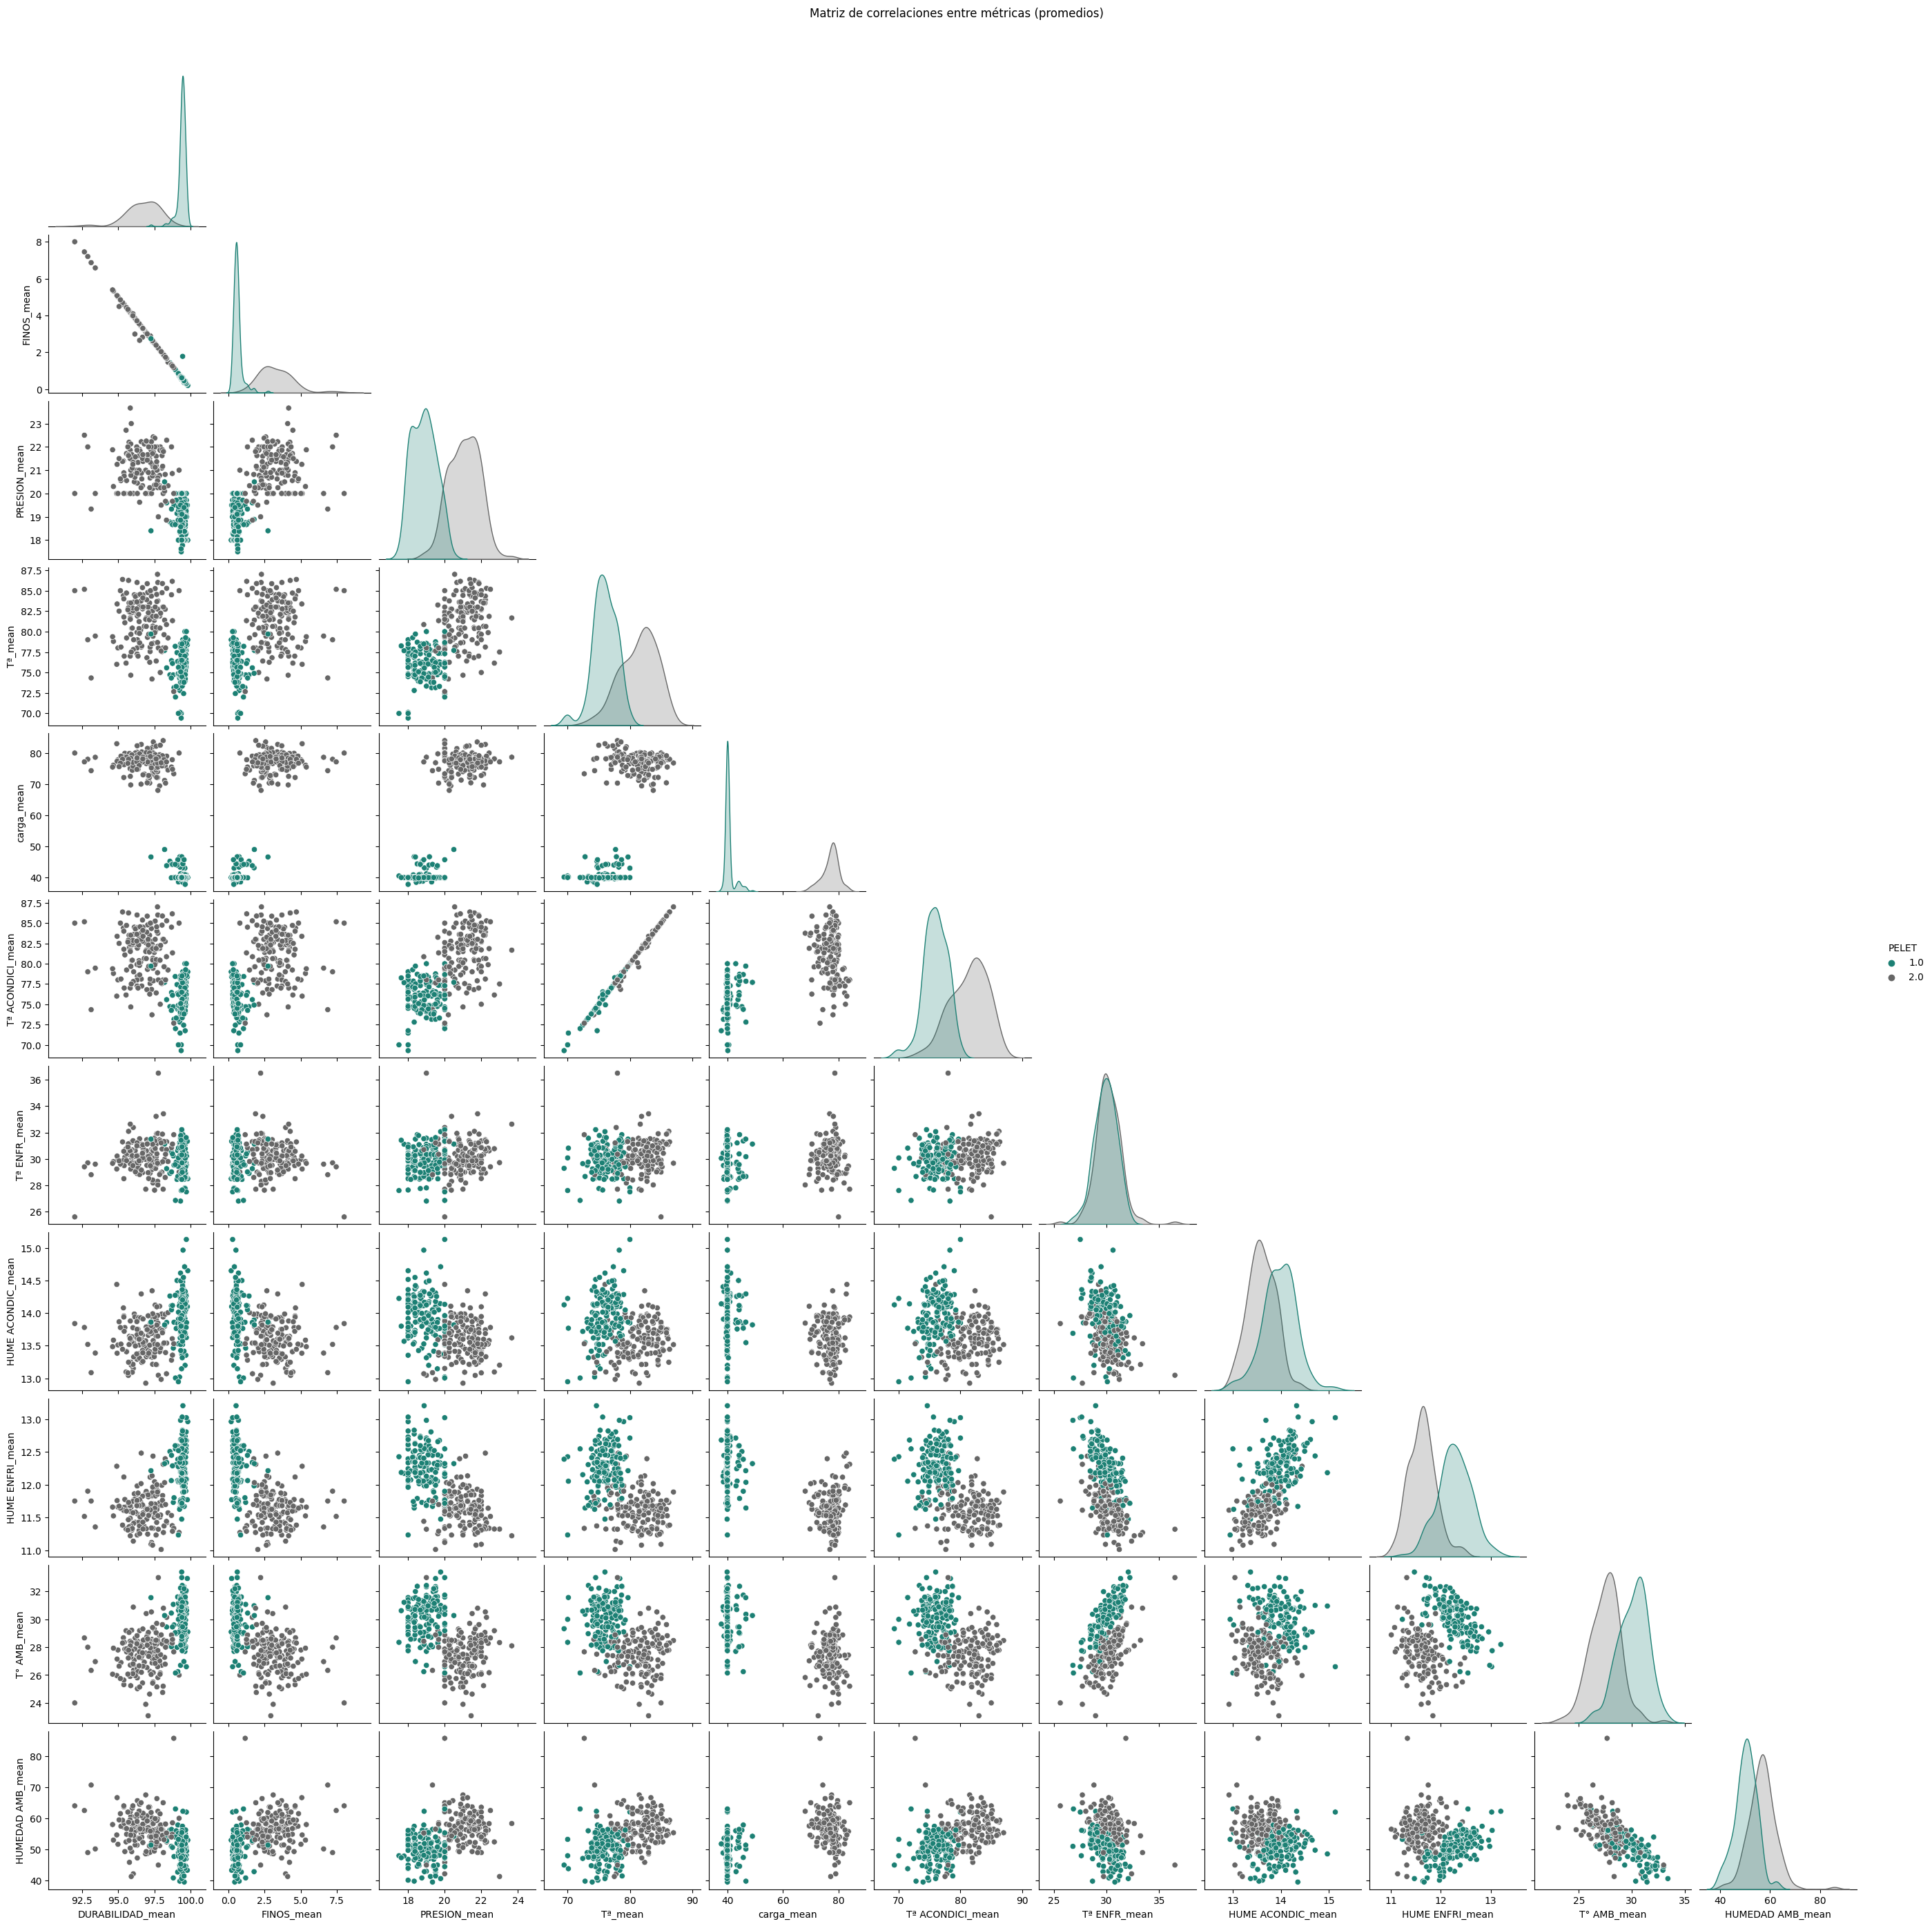

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

pairplot_pel_mean = by_date_stats_pel[
    ['PELET'] + [col for col in by_date_stats_pel.columns if col.endswith('_mean')]
]

sns.pairplot(pairplot_pel_mean, hue="PELET", diag_kind="kde", corner=True,  palette=palette_pel,)
plt.suptitle("Matriz de correlaciones entre métricas (promedios)", y=1.02)
plt.show()


In [19]:
from scipy.stats import gaussian_kde
from scipy.stats import linregress
def plot_scatter_with_regression_plotly(
    df, x, y, hue=None, palette=None, show_corr=True,
    fit_by_group=False, html_path=None, background="white"
):
    """
    Crea un scatterplot en Plotly con línea(s) de regresión y correlación de Pearson.

    Parámetros:
        df : DataFrame con datos.
        x : str, columna en eje X.
        y : str, columna en eje Y.
        hue : str opcional, columna para diferenciar grupos.
        palette : dict o lista de colores por grupo.
        show_corr : bool, mostrar coeficiente de correlación.
        fit_by_group : bool, si True ajusta regresión por grupo (hue).
        html_path : str, si se especifica, guarda como HTML.
        background : "white" o "transparent".
    """
    fig = go.Figure()
    corr_texts = []

    bg_color = "white" if background == "white" else "rgba(0,0,0,0)"

    if hue:
        groups = df[hue].dropna().unique()
        for i, group in enumerate(groups):
            group_df = df[df[hue] == group].dropna(subset=[x, y])

            color = palette[group] if palette and group in palette else None

            # Scatter
            fig.add_trace(go.Scatter(
                x=group_df[x],
                y=group_df[y],
                mode="markers",
                name=f"{group}",
                marker=dict(color=color),
                showlegend=True
            ))

            # Línea de regresión por grupo
            if fit_by_group and len(group_df) > 1:
                slope, intercept, r_value, *_ = linregress(group_df[x], group_df[y])
                x_range = pd.Series(sorted(group_df[x].unique()))
                y_fit = slope * x_range + intercept

                fig.add_trace(go.Scatter(
                    x=x_range,
                    y=y_fit,
                    mode="lines",
                    line=dict(dash="dot", color=color),
                    name=f"Tendencia {group}",
                    showlegend=False
                ))

                if show_corr:
                    corr_texts.append(f"{group}: r = {r_value:.2f}")
    else:
        # Sin hue
        df = df.dropna(subset=[x, y])
        fig.add_trace(go.Scatter(
            x=df[x],
            y=df[y],
            mode="markers",
            name="Datos"
        ))

        if len(df) > 1:
            slope, intercept, r_value, *_ = linregress(df[x], df[y])
            x_range = pd.Series(sorted(df[x].unique()))
            y_fit = slope * x_range + intercept

            fig.add_trace(go.Scatter(
                x=x_range,
                y=y_fit,
                mode="lines",
                line=dict(color="red"),
                name="Regresión lineal"
            ))

            if show_corr:
                corr_texts.append(f"r = {r_value:.2f}")

    fig.update_layout(
        title=f"Relación entre {x} y {y}" + (" | " + " | ".join(corr_texts) if corr_texts else ""),
        xaxis_title=x,
        yaxis_title=y,
        height=500,
        width=800,
        plot_bgcolor=bg_color,
        paper_bgcolor=bg_color,
        font=dict(color="black")
    )

    fig.update_xaxes(color="black")
    fig.update_yaxes(color="black")

    return fig


In [20]:
f = plot_scatter_with_regression_plotly(
    df=by_date_stats_pel,
    x="Tª ENFR_mean",
    y="HUME ENFRI_mean",
    hue="PELET",
    fit_by_group=True,  # línea por cada PELET
    show_corr=True,
    palette=palette_pel,
    #html_path=f"{ROOT_IMAGEN}/relacion_temp_enfriamento_hum_enfriamiento.html"
)
s3.save_plotly_html(f, f"relacion_temp_enfriamento_hum_enfriamiento.html")
f.show()

In [21]:
f = plot_scatter_with_regression_plotly(
    df=by_date_stats_pel,
    x="Tª ACONDICI_mean",
    y="HUME ACONDIC_mean",
    hue="PELET",
    fit_by_group=True,  # línea por cada PELET
    show_corr=True,
    palette=palette_pel,
    #html_path=f"{ROOT_IMAGEN}/relacion_temp_acond_hum_acond.html"
)
s3.save_plotly_html(f, "relacion_temp_acond_hum_acond.html")
f.show()

## Diferencia entre la temperatura de enfriamiento y Ambiente

In [22]:
process_pel["delta_temp_enf_amb"] = process_pel['Tª ENFR'] - process_pel['T° AMB']

In [23]:
process_pel["delta_temp_enf_amb"].describe()

count    2680.000000
mean        1.315269
std         2.748737
min       -11.000000
25%        -0.700000
50%         1.100000
75%         3.200000
max        13.800000
Name: delta_temp_enf_amb, dtype: float64

In [24]:

def plot_corr_matrix_by_group(df, group_col, metric_suffix='_mean', palette=None):
    # Obtener las columnas numéricas
    metric_cols = [col for col in df.columns if col.endswith(metric_suffix)]
    pelets = df[group_col].unique()

    n = len(pelets)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10* ncols, 10 * nrows))
    axes = axes.flatten()

    for i, pelet in enumerate(pelets):
        subset = df[df[group_col] == pelet][metric_cols]
        corr = subset.corr()

        sns.heatmap(
            corr,
            ax=axes[i],
            annot=True,
            cmap="RdBu_r",
            center=0,
            vmin=-1,
            vmax=1,
            cbar=False,
            linewidths=0.5,
            square=True
        )
        axes[i].set_title(f"Matriz de correlación: {pelet}", fontsize=12)

    # Ocultar ejes vacíos si hay más subplots que pelets
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.suptitle("Matriz de correlación por peletizadora", fontsize=16, y=1.02)
    plt.show()


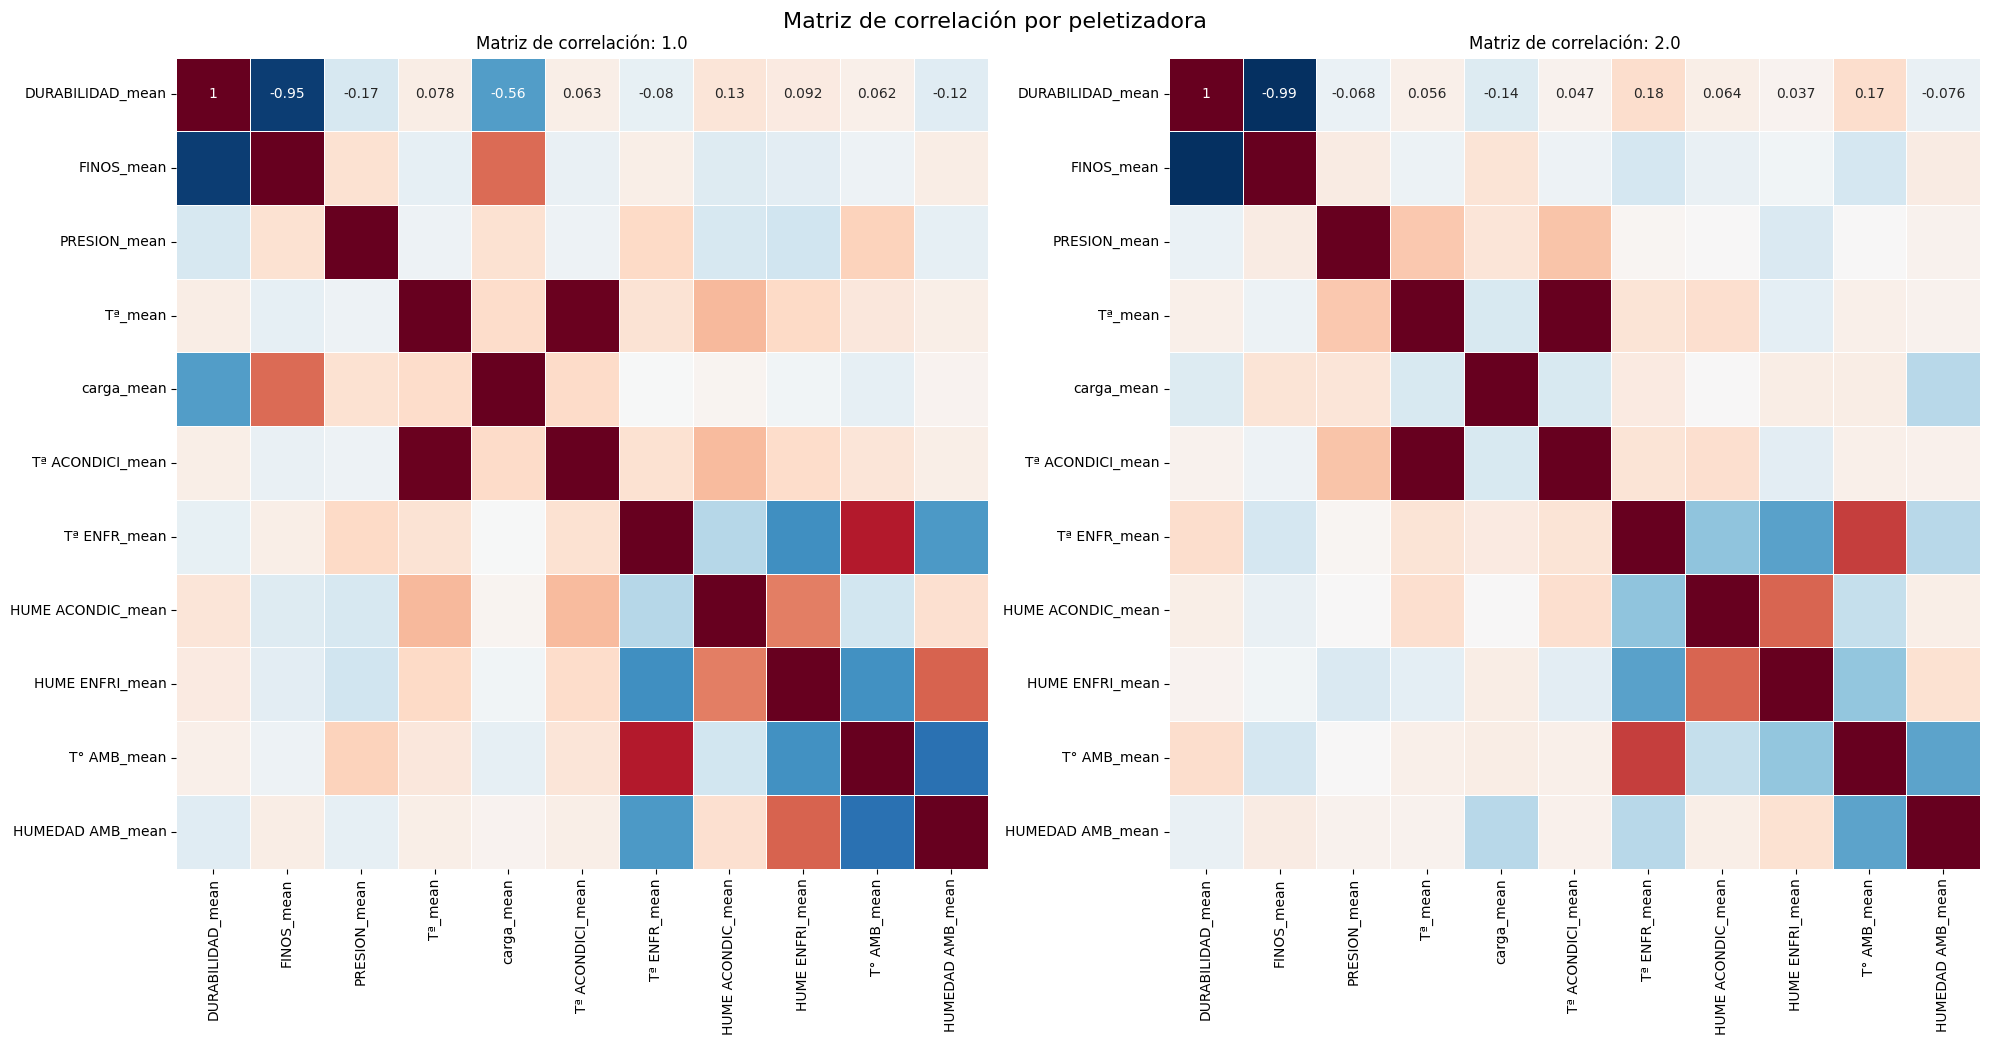

In [25]:
by_date_stats_pel_corr = by_date_stats_pel.dropna()
plot_corr_matrix_by_group(by_date_stats_pel_corr, group_col="PELET", metric_suffix="_mean")


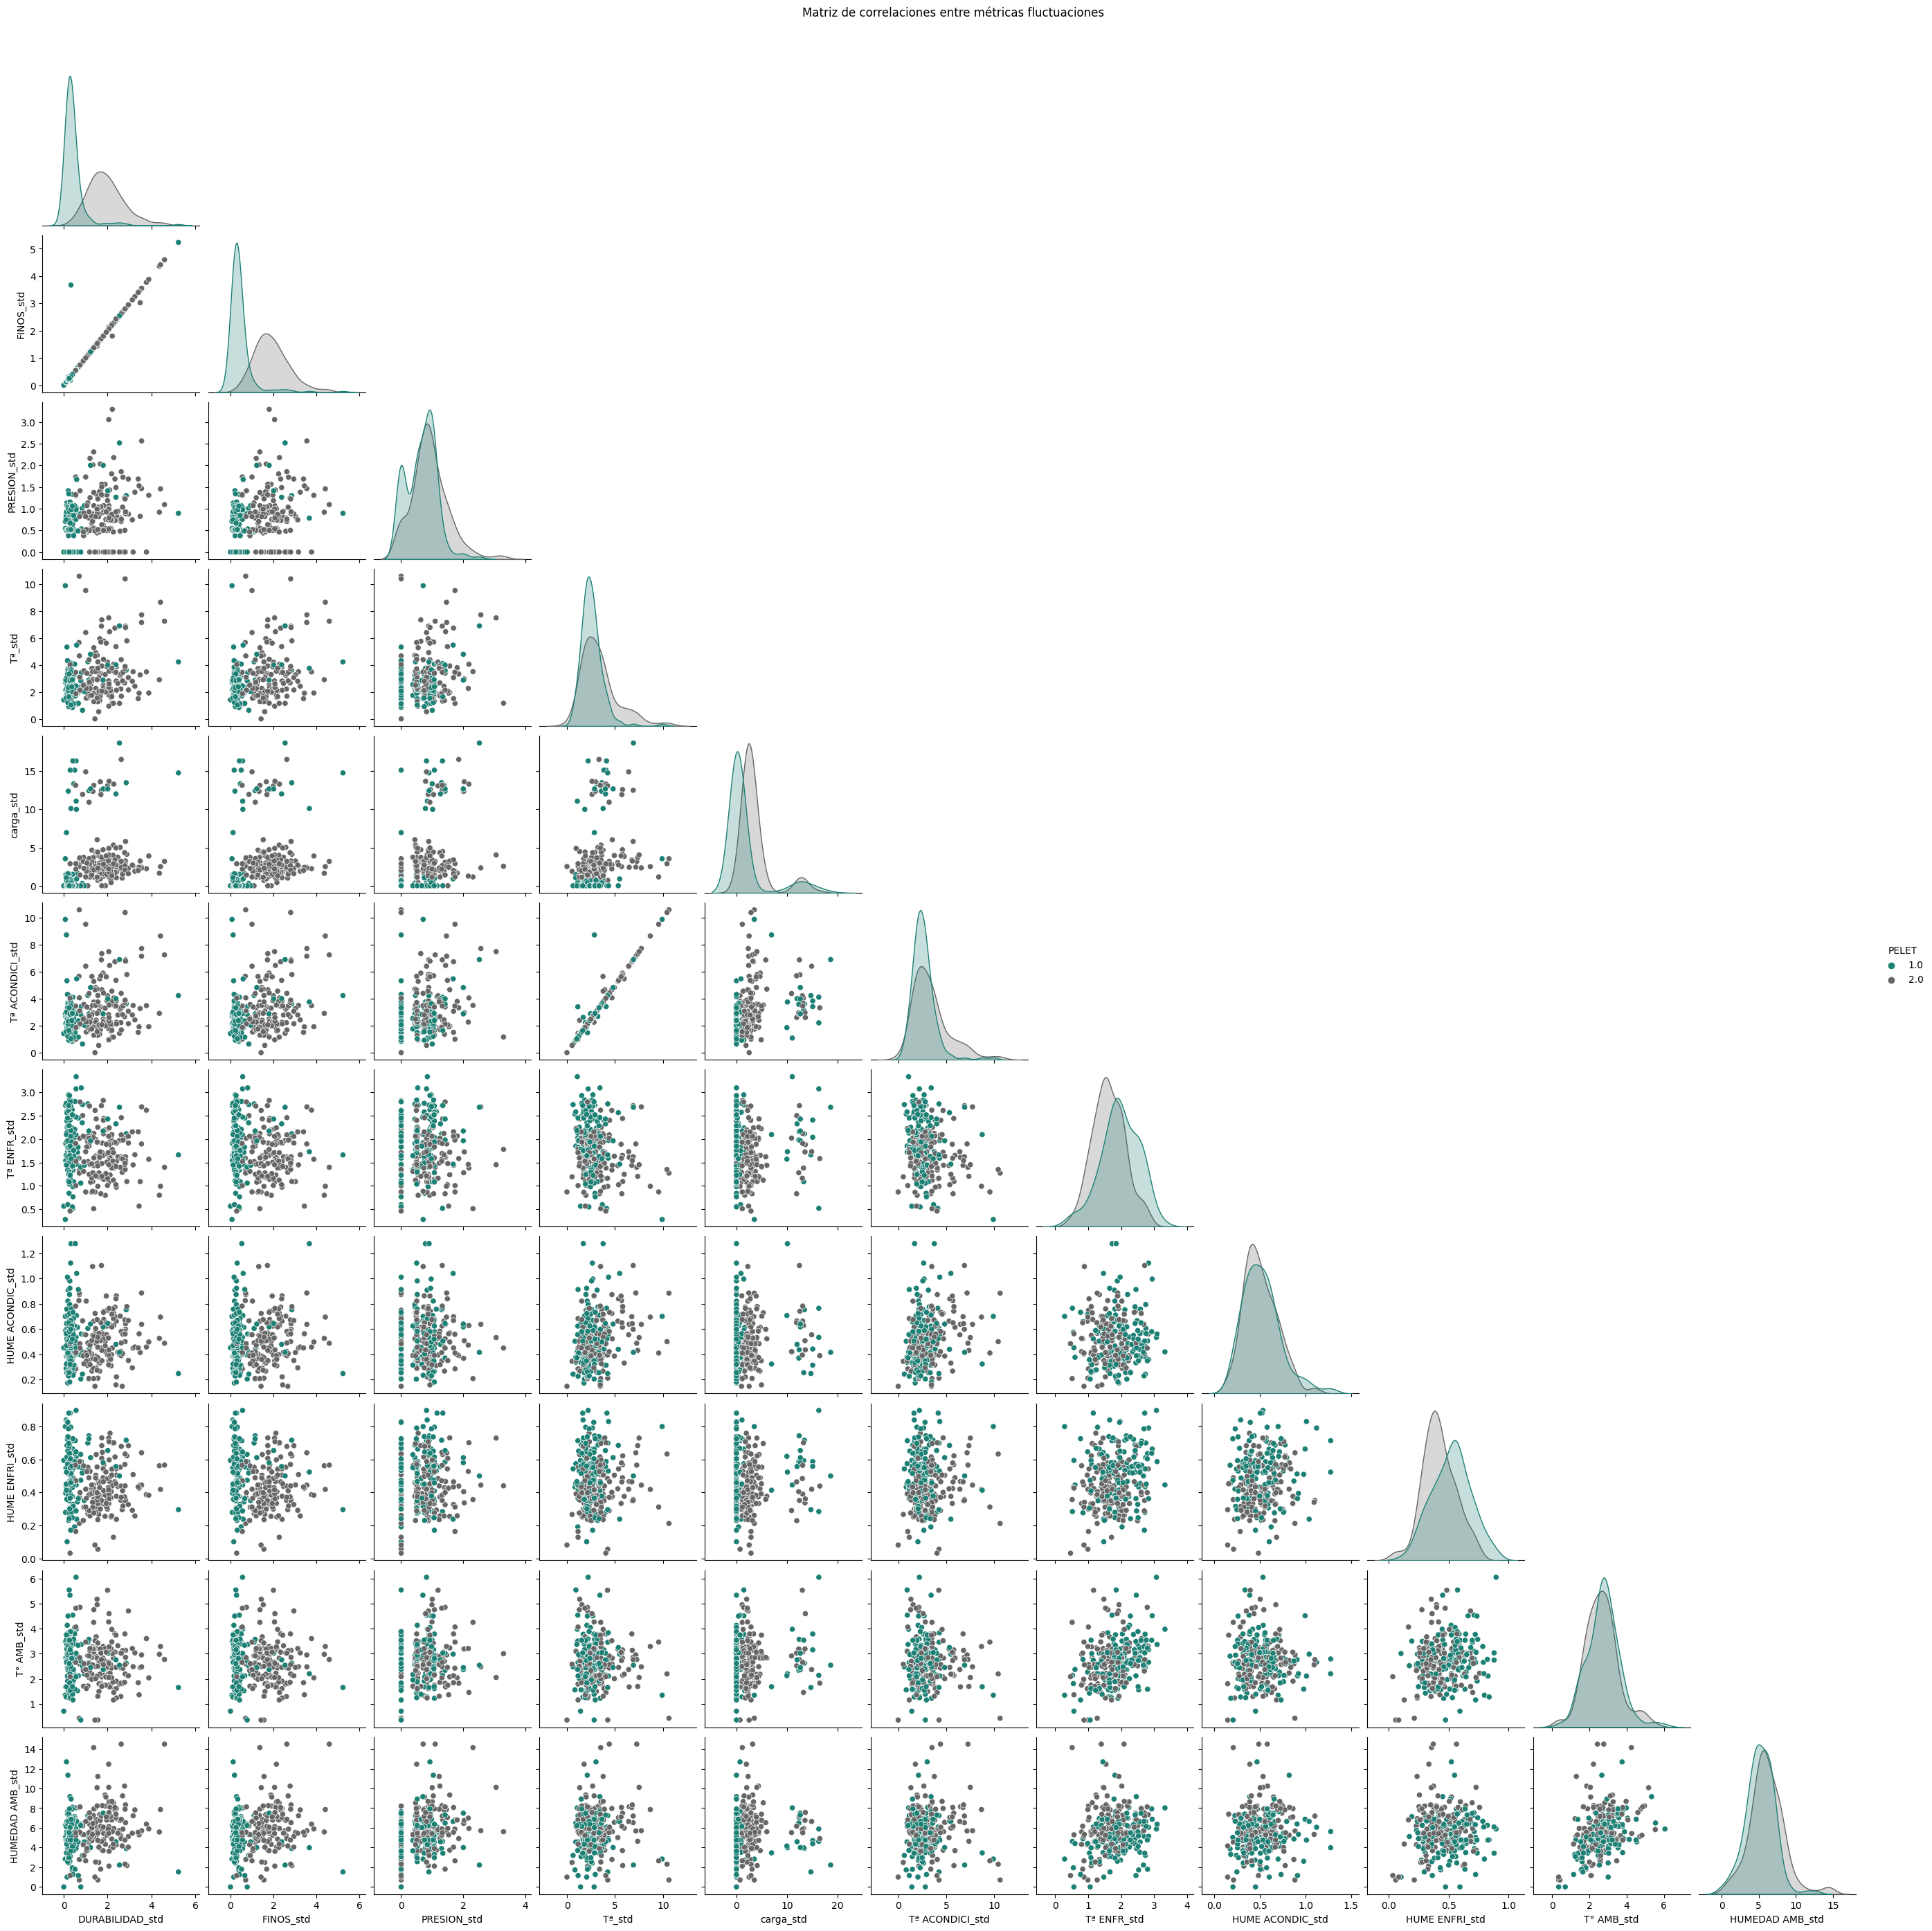

In [26]:

pairplot_pel_std = by_date_stats_pel[
    ['PELET'] + [col for col in by_date_stats_pel.columns if col.endswith('_std')]
]

sns.pairplot(pairplot_pel_std, hue="PELET", diag_kind="kde", corner=True,   palette=palette_pel,
)
plt.suptitle("Matriz de correlaciones entre métricas fluctuaciones", y=1.02)
plt.show()


In [27]:
# TODO Dietas por Pele, ¿Están homogeneaamete cargadas, se estan realizando todas las dietas en todas las pelets?
by_product_pel = process_pel.groupby(["PRODUCTO", "PELET"])[cols_metric].agg(['mean', 'count'])
by_product_pel.columns = [f"{col}_{stat}" for col, stat in by_product_pel.columns]
by_product_pel = by_product_pel.reset_index()
by_product_pel.isnull().sum()

PRODUCTO              0
PELET                 0
DURABILIDAD_mean      0
DURABILIDAD_count     0
FINOS_mean            0
FINOS_count           0
PRESION_mean          0
PRESION_count         0
Tª_mean               0
Tª_count              0
carga_mean            0
carga_count           0
Tª ACONDICI_mean      0
Tª ACONDICI_count     0
Tª ENFR_mean          0
Tª ENFR_count         0
HUME ACONDIC_mean     0
HUME ACONDIC_count    0
HUME ENFRI_mean       0
HUME ENFRI_count      0
T° AMB_mean           0
T° AMB_count          0
HUMEDAD AMB_mean      0
HUMEDAD AMB_count     0
dtype: int64

In [28]:
# Se ha peletizado de forma mezclada las diertas en ambas peletizadoras

In [29]:
process_pel

Unnamed: 0      FECHA  MES    LOTE   CODIGO               PRODUCTO  \
1            NaN 2025-07-28  7.0  2569.0  703-298     CEBA FINALIZACION    
2            NaN 2025-07-24  7.0  2867.0  212-518  LACTANCIA  MULTIPARAS   
3            NaN 2025-07-25  7.0  2867.0  212-518  LACTANCIA  MULTIPARAS   
4            NaN 2025-07-24  7.0  2866.0  110-398            GESTACION 2   
5            NaN 2025-07-24  7.0  2866.0  110-398            GESTACION 2   
...          ...        ...  ...     ...      ...                    ...   
2676         NaN 2024-01-02  1.0  1705.0  610-596            PRELEVANTE    
2677         NaN 2024-01-02  1.0  1705.0  610-596            PRELEVANTE    
2678         NaN 2024-01-02  1.0  1705.0  610-596            PRELEVANTE    
2679         NaN 2024-01-02  1.0  1705.0  610-596            PRELEVANTE    
2680         NaN 2024-01-02  1.0  1705.0  610-596            PRELEVANTE    

      TURNO  PELET  DURABILIDAD  FINOS  ...  AGUA  T° AMB  HUMEDAD AMB  \
1       1.0    2.0         98.3    1.7  ...   0.0    26.0         63.0   
2       3.0    2.0         99.0    1.0  ...   NaN    26.8         57.0   
3       3.0    1.0         99.6    0.4  ...   NaN    29.5         50.0   
4       3.0    2.0         99.3    0.7  ...   0.0    26.4         55.0   
5       3.0    1.0         99.6    0.4  ...   0.0    28.9         49.0   
...     ...    ...          ...    ...  ...   ...     ...          ...   
2676    1.0    2.0         96.1    3.9  ...   NaN    25.5         72.0   
2677    1.0    1.0         99.6    0.4  ...   NaN    28.0         68.0   
2678    1.0    2.0         96.1    3.9  ...   NaN    23.9         71.0   
2679    1.0    1.0         99.1    0.9  ...   NaN    26.0         68.0   
2680    1.0    2.0         96.7    3.3  ...   NaN    23.1         69.0   

        OBSERVACIONES  # DADO      HORA  Unnamed: 23  Unnamed: 24  month  \
1             AMP 194    M 07  09:15:00          NaN          NaN      7   
2     AMP 104.4-118.1   MT 07  03:35:00          NaN          NaN      7   
3           AMP 86.07     M 4  04:00:00          NaN          NaN      7   
4     AMP 107.5-119.0   MT 07  02:15:00          NaN          NaN      7   
5           AMP 80.94     M 4  02:00:00          NaN          NaN      7   
...               ...     ...       ...          ...          ...    ...   
2676          AMP 105   MT 07  10:30:00          NaN          NaN      1   
2677        AMP 103.7     M 4  10:00:00          NaN          NaN      1   
2678          AMP 103   MT 07  08:40:00          NaN          NaN      1   
2679        AMP 99.25     M 4  08:00:00          NaN          NaN      1   
2680          AMP 103   MT 07  07:20:00          NaN          NaN      1   

      delta_temp_enf_amb  
1                    6.3  
2                   12.8  
3                    0.7  
4                    5.5  
5                    4.0  
...                  ...  
2676                 6.8  
2677                 3.3  
2678                 6.3  
2679                -0.3  
2680                 7.3  

[2680 rows x 27 columns]

In [30]:
cols_metric = [
    'DURABILIDAD', 'FINOS', 'PRESION', 'Tª', 'carga',
    'Tª ACONDICI', 'Tª ENFR', 'HUME ACONDIC', 'HUME ENFRI', 'T° AMB', 'HUMEDAD AMB'
]

REF = ["FECHA", "PELET", "LOTE"]
quality_lote = process_pel.groupby(REF)[cols_metric].agg(['mean', 'std', 'count'])
quality_lote.columns = [f"{col}_{stat}" for col, stat in quality_lote.columns]
quality_lote = quality_lote.reset_index()

## Datos de producción: Analizar rendimiento y tiempos muertos

In [31]:
prod_2 = s3.read_excel(
    "raw/cervalle/TVC Pellet 2.xlsx",
    sheet_name='Rendimiento Pelet 2',

)
prod_2.columns = [cols.strip() for cols in prod_2.columns]
prod_2["PELET"] = 2
prod_2["META"] = 10.8


#prod_1 = pd.read_excel("data_cervalle/TVC_Pellet_1.xlsx", sheet_name='Rendimiento Pelet 1',skiprows=1)
prod_1 = s3.read_excel(
    "raw/cervalle/TVC_Pellet_1.xlsx",
     sheet_name='Rendimiento Pelet 1',skiprows=1

)
prod_1.columns = [str(cols).strip() for cols in prod_1.columns]
prod_1["PELET"] = 1
prod_1["META"] = 2.8


In [32]:
prod = pd.concat([prod_1, prod_2])
rename = {"Fecha": "FECHA", "Lote": "LOTE"}
prod.rename(columns=rename, inplace=True)

# Convertir a tipo datetime (maneja ambos formatos)
prod['Hora Inicial2'] = pd.to_datetime(prod['Hora Inicial'], errors='coerce')

# Formatear como solo HH:MM:SS
prod['Hora Inicial2'] = prod['Hora Inicial2'].dt.strftime('%H:%M:%S')

In [33]:
prod

Año  Mes      FECHA Hora Inicial Hora Final   Codigo  \
0      2022    1 2022-01-03     06:00:00   06:15:00       al   
1      2022    1 2022-01-03     06:15:00   07:30:00      al2   
2      2022    1 2022-01-03     07:30:00   08:50:00  100-405   
3      2022    1 2022-01-03     08:50:00   09:08:00       fv   
4      2022    1 2022-01-03     09:08:00   11:56:00  703-298   
...     ...  ...        ...          ...        ...      ...   
15758  1900    1        NaT     00:00:00        NaN      NaN   
15759  1900    1        NaT     00:00:00        NaN      NaN   
15760  1900    1        NaT     00:00:00        NaN      NaN   
15761  1900    1        NaT     00:00:00        NaN      NaN   
15762  1900    1        NaT     00:00:00        NaN      NaN   

                                   PRODUCTO Supervisor  Turno    LOTE  ...  \
0                              ALISTAMIENTO    william    1.0     NaN  ...   
1                 Tiempo fuera de Parametro    william    1.0     NaN  ...   
2                        Gestación preparto    william    1.0  6338.0  ...   
3                   NOVEDAD LINEAS DE VAPOR    william    1.0     NaN  ...   
4      Ceba Premex Accuremax 0.5 gr Tilovic    william    1.0  6347.0  ...   
...                                     ...        ...    ...     ...  ...   
15758                                   NaN        NaN    NaN     NaN  ...   
15759                                   NaN        NaN    NaN     NaN  ...   
15760                                   NaN        NaN    NaN     NaN  ...   
15761                                   NaN        NaN    NaN     NaN  ...   
15762                                   NaN        NaN    NaN     NaN  ...   

       Temperatura Acondicionada  Presion  Columna1  PELET  META H Inicial  \
0                            NaN      NaN       NaN      1   2.8       NaN   
1                            NaN      NaN       NaN      1   2.8       NaN   
2                            NaN      NaN       NaN      1   2.8       NaN   
3                            NaN      NaN       NaN      1   2.8       NaN   
4                            NaN      NaN       NaN      1   2.8       NaN   
...                          ...      ...       ...    ...   ...       ...   
15758                        NaN      NaN       NaN      2  10.8       NaN   
15759                        NaN      NaN       NaN      2  10.8       NaN   
15760                        NaN      NaN       NaN      2  10.8       NaN   
15761                        NaN      NaN       NaN      2  10.8       NaN   
15762                        NaN      NaN       NaN      2  10.8       NaN   

       H final Semana Pelet 2  Columna2 Hora Inicial2  
0          NaN            NaN       NaN           NaN  
1          NaN            NaN       NaN           NaN  
2          NaN            NaN       NaN           NaN  
3          NaN            NaN       NaN           NaN  
4          NaN            NaN       NaN           NaN  
...        ...            ...       ...           ...  
15758      NaN           52.0       NaN           NaN  
15759      NaN           52.0       NaN           NaN  
15760      NaN           52.0       NaN           NaN  
15761      NaN           52.0       NaN           NaN  
15762      NaN           52.0       NaN           NaN  

[31560 rows x 30 columns]

In [34]:
prod = prod[prod["FECHA"].notnull()].copy()
prod["FECHA"] = pd.to_datetime(prod["FECHA"])

In [35]:
prod[prod["LOTE"].isnull()]["Actividad"].value_counts(dropna=False)

Obligatorio       11537
Improductivo       3002
Mantenimiento      1113
NaN                 211
Agente externo      119
Productivo           12
Calidad               4
Name: Actividad, dtype: int64

In [36]:
prod["LOTE"].isnull().sum()

15998

In [37]:
prod[prod["LOTE"].isnull()]

Año  Mes      FECHA         Hora Inicial           Hora Final Codigo  \
0      2022    1 2022-01-03             06:00:00             06:15:00     al   
1      2022    1 2022-01-03             06:15:00             07:30:00    al2   
3      2022    1 2022-01-03             08:50:00             09:08:00     fv   
5      2022    1 2022-01-03             11:56:00             12:16:00     cp   
6      2022    1 2022-01-03             12:16:00             14:00:00     fc   
...     ...  ...        ...                  ...                  ...    ...   
15420  2025    7 2025-07-24  1900-01-01 01:38:00  1900-01-01 01:45:00     CP   
15422  2025    7 2025-07-24  1900-01-01 03:05:00  1900-01-01 03:16:00     CP   
15424  2025    7 2025-07-24  1900-01-01 04:16:00  1900-01-01 04:27:00     CP   
15426  2025    7 2025-07-24  1900-01-01 05:20:00  1900-01-01 05:35:00     CP   
15427  2025    7 2025-07-24  1900-01-01 05:35:00  1900-01-01 06:00:00     OT   

                        PRODUCTO Supervisor  Turno  LOTE  ...  \
0                   ALISTAMIENTO    william    1.0   NaN  ...   
1      Tiempo fuera de Parametro    william    1.0   NaN  ...   
3        NOVEDAD LINEAS DE VAPOR    william    1.0   NaN  ...   
5             CAMBIO DE PRODUCTO    william    1.0   NaN  ...   
6                 FALTA DE CARGA    william    1.0   NaN  ...   
...                          ...        ...    ...   ...  ...   
15420            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15422            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15424            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15426            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15427                      OTROS    Nestor     3.0   NaN  ...   

       Temperatura Acondicionada  Presion  Columna1  PELET  META H Inicial  \
0                            NaN      NaN       NaN      1   2.8       NaN   
1                            NaN      NaN       NaN      1   2.8       NaN   
3                            NaN      NaN       NaN      1   2.8       NaN   
5                            NaN      NaN       NaN      1   2.8       NaN   
6                            NaN      NaN       NaN      1   2.8       NaN   
...                          ...      ...       ...    ...   ...       ...   
15420                        NaN      NaN       NaN      2  10.8       NaN   
15422                        NaN      NaN       NaN      2  10.8       NaN   
15424                        NaN      NaN       NaN      2  10.8       NaN   
15426                        NaN      NaN       NaN      2  10.8       NaN   
15427                        NaN      NaN       NaN      2  10.8       NaN   

       H final Semana Pelet 2  Columna2 Hora Inicial2  
0          NaN            NaN       NaN           NaN  
1          NaN            NaN       NaN           NaN  
3          NaN            NaN       NaN           NaN  
5          NaN            NaN       NaN           NaN  
6          NaN            NaN       NaN           NaN  
...        ...            ...       ...           ...  
15420      NaN           30.0       NaN      01:38:00  
15422      NaN           30.0       NaN      03:05:00  
15424      NaN           30.0       NaN      04:16:00  
15426      NaN           30.0       NaN      05:20:00  
15427      NaN           30.0       NaN      05:35:00  

[15998 rows x 30 columns]

In [38]:
prod[prod["LOTE"].isnull()]["Actividad"].value_counts(dropna=False)

Obligatorio       11537
Improductivo       3002
Mantenimiento      1113
NaN                 211
Agente externo      119
Productivo           12
Calidad               4
Name: Actividad, dtype: int64

In [39]:
prod[prod["LOTE"].notnull()]["Actividad"].value_counts(dropna=False)

Productivo       14510
NaN                179
Obligatorio          5
Improductivo         3
Mantenimiento        2
Name: Actividad, dtype: int64

In [40]:
row_bad_marker = prod[(prod["LOTE"].notnull()) & (prod["Actividad"] != 'Productivo')]

prod_good = prod[~prod["LOTE"].isin(row_bad_marker["LOTE"])]
prod_good

Año  Mes      FECHA         Hora Inicial           Hora Final  \
0      2022    1 2022-01-03             06:00:00             06:15:00   
1      2022    1 2022-01-03             06:15:00             07:30:00   
2      2022    1 2022-01-03             07:30:00             08:50:00   
3      2022    1 2022-01-03             08:50:00             09:08:00   
4      2022    1 2022-01-03             09:08:00             11:56:00   
...     ...  ...        ...                  ...                  ...   
15423  2025    7 2025-07-24  1900-01-01 03:16:00  1900-01-01 04:16:00   
15424  2025    7 2025-07-24  1900-01-01 04:16:00  1900-01-01 04:27:00   
15425  2025    7 2025-07-24  1900-01-01 04:27:00  1900-01-01 05:20:00   
15426  2025    7 2025-07-24  1900-01-01 05:20:00  1900-01-01 05:35:00   
15427  2025    7 2025-07-24  1900-01-01 05:35:00  1900-01-01 06:00:00   

        Codigo                                     PRODUCTO Supervisor  Turno  \
0           al                                 ALISTAMIENTO    william    1.0   
1          al2                    Tiempo fuera de Parametro    william    1.0   
2      100-405                           Gestación preparto    william    1.0   
3           fv                      NOVEDAD LINEAS DE VAPOR    william    1.0   
4      703-298         Ceba Premex Accuremax 0.5 gr Tilovic    william    1.0   
...        ...                                          ...        ...    ...   
15423  212-518                         Lactancia Multiparas    Nestor     3.0   
15424       CP                              CAMBIO DE DIETA    Nestor     3.0   
15425  601-562  Levante Premex Carfenicol 2.4kg + Clort 3kg    Nestor     3.0   
15426       CP                              CAMBIO DE DIETA    Nestor     3.0   
15427       OT                                        OTROS    Nestor     3.0   

         LOTE  ...  Temperatura Acondicionada  Presion  Columna1  PELET  META  \
0         NaN  ...                        NaN      NaN       NaN      1   2.8   
1         NaN  ...                        NaN      NaN       NaN      1   2.8   
2      6338.0  ...                        NaN      NaN       NaN      1   2.8   
3         NaN  ...                        NaN      NaN       NaN      1   2.8   
4      6347.0  ...                        NaN      NaN       NaN      1   2.8   
...       ...  ...                        ...      ...       ...    ...   ...   
15423  2867.0  ...                        NaN      NaN       NaN      2  10.8   
15424     NaN  ...                        NaN      NaN       NaN      2  10.8   
15425  2868.0  ...                        NaN      NaN       NaN      2  10.8   
15426     NaN  ...                        NaN      NaN       NaN      2  10.8   
15427     NaN  ...                        NaN      NaN       NaN      2  10.8   

      H Inicial  H final Semana Pelet 2  Columna2 Hora Inicial2  
0           NaN      NaN            NaN       NaN           NaN  
1           NaN      NaN            NaN       NaN           NaN  
2           NaN      NaN            NaN       NaN           NaN  
3           NaN      NaN            NaN       NaN           NaN  
4           NaN      NaN            NaN       NaN           NaN  
...         ...      ...            ...       ...           ...  
15423   1759.26  1760.27           30.0       NaN      03:16:00  
15424       NaN      NaN           30.0       NaN      04:16:00  
15425   1760.27  1761.18           30.0       NaN      04:27:00  
15426       NaN      NaN           30.0       NaN      05:20:00  
15427       NaN      NaN           30.0       NaN      05:35:00  

[30432 rows x 30 columns]

In [41]:
row_productive = prod_good[prod_good["Actividad"] == 'Productivo'].copy()
row_other = prod_good[prod_good["Actividad"] != 'Productivo'].copy()

row_productive["rendimiento_reloj"] = row_productive["Toneladas"] / row_productive["Tiempo Trabajo Hora"]
row_productive["rendimiento_horometro"] = row_productive["Toneladas"] / row_productive["Tiempo Trabajo Horometro"]

In [42]:
row_productive["rendimiento_reloj"].describe()

count    14434.000000
mean         7.421232
std          7.939169
min       -112.800000
25%          3.214286
50%          7.500000
75%         11.360947
max        678.000000
Name: rendimiento_reloj, dtype: float64

In [43]:
def remove_outliers_iqr_group(df, group_col, target_col):
    def filter_group(group):
        Q1 = group[target_col].quantile(0.25)
        Q3 = group[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[target_col] >= lower) & (group[target_col] <= upper)]

    return df.groupby(group_col, group_keys=False).apply(filter_group)


row_productive = remove_outliers_iqr_group(row_productive, 'PELET', 'rendimiento_reloj')
row_productive = remove_outliers_iqr_group(row_productive, 'PELET', 'rendimiento_horometro')

In [44]:
row_productive

Año  Mes      FECHA         Hora Inicial           Hora Final  \
2      2022    1 2022-01-03             07:30:00             08:50:00   
13     2022    1 2022-01-03             22:59:00  1900-01-01 00:37:00   
19     2022    1 2022-01-04             17:39:00             19:11:00   
27     2022    1 2022-01-04  1900-01-01 01:53:00  1900-01-01 04:39:00   
32     2022    1 2022-01-05             07:00:00             10:26:00   
...     ...  ...        ...                  ...                  ...   
15416  2025    7 2025-07-24             19:00:00             21:40:00   
15419  2025    7 2025-07-24             22:30:00  1900-01-01 01:38:00   
15421  2025    7 2025-07-24  1900-01-01 01:45:00  1900-01-01 03:05:00   
15423  2025    7 2025-07-24  1900-01-01 03:16:00  1900-01-01 04:16:00   
15425  2025    7 2025-07-24  1900-01-01 04:27:00  1900-01-01 05:20:00   

        Codigo                                          PRODUCTO Supervisor  \
2      100-405                                Gestación preparto    william   
13     703-298              Ceba Premex Accuremax 0.5 gr Tilovic     felipe   
19     601-562       Levante Premex Carfenicol 2.4kg + Clort 3kg     felipe   
27     550-427  Iniciacion Premex Doxiphar 500gr + Denagar 1.8kg    Nestor    
32     703-177                           Ceba cachorros tilcomix    william   
...        ...                                               ...        ...   
15416  703-167                            Ceba Premex Medicado 2   Robinson   
15419  920-597                                 Hembras reemplazo    Nestor    
15421  110-398                       Gestacion Md Premex Clort 4    Nestor    
15423  212-518                              Lactancia Multiparas    Nestor    
15425  601-562       Levante Premex Carfenicol 2.4kg + Clort 3kg    Nestor    

       Turno    LOTE  ...  Columna1  PELET  META  H Inicial  H final  \
2        1.0  6338.0  ...       NaN      1   2.8        NaN      NaN   
13       3.0  6347.0  ...       NaN      1   2.8        NaN      NaN   
19       2.0  6351.0  ...       NaN      1   2.8        NaN      NaN   
27       3.0  6353.0  ...       NaN      1   2.8        NaN      NaN   
32       1.0  6355.0  ...       NaN      1   2.8        NaN      NaN   
...      ...     ...  ...       ...    ...   ...        ...      ...   
15416    2.0  2864.0  ...       NaN      2  10.8    1752.32  1755.11   
15419    3.0  2865.0  ...       NaN      2  10.8    1755.11  1758.10   
15421    3.0  2866.0  ...       NaN      2  10.8    1758.10  1759.26   
15423    3.0  2867.0  ...       NaN      2  10.8    1759.26  1760.27   
15425    3.0  2868.0  ...       NaN      2  10.8    1760.27  1761.18   

      Semana Pelet 2  Columna2 Hora Inicial2  rendimiento_reloj  \
2                NaN       NaN           NaN           3.000000   
13               NaN       NaN           NaN           3.673469   
19               NaN       NaN           NaN           2.608696   
27               NaN       NaN      01:53:00           3.614458   
32               NaN       NaN           NaN           2.912621   
...              ...       ...           ...                ...   
15416           30.0       NaN           NaN          12.375000   
15419           30.0       NaN           NaN          10.212766   
15421           30.0       NaN      01:45:00          10.500000   
15423           30.0       NaN      03:16:00          13.200000   
15425           30.0       NaN      04:27:00          12.452830   

      rendimiento_horometro  
2                  2.469136  
13                 4.316547  
19                 2.439024  
27                 3.412969  
32                 3.154574  
...                     ...  
15416             11.827957  
15419             10.702341  
15421             12.068966  
15423             13.069307  
15425             12.087912  

[10617 rows x 32 columns]

In [45]:
#plot_distributions(row_productive, ['rendimiento_reloj', 'rendimiento_horometro'], group_col="PELET", palette=palette_pel)
plot_distributions_plotly(
    df=row_productive,
    columns=['rendimiento_reloj', 'rendimiento_horometro'],
    group_col="PELET",
    palette=palette_pel,
    #html_path=f"{ROOT_IMAGEN}/distribuciones.html"
)


In [46]:
#Revisión
row_productive["rendimiento_reloj"] = row_productive["Toneladas"] / row_productive["Tiempo Trabajo Hora"]
row_productive["rendimiento_horometro"] = row_productive["Toneladas"] / row_productive["Tiempo Trabajo Horometro"]
row_productive["year"] = row_productive["FECHA"].dt.year
row_productive["month"] = row_productive["FECHA"].dt.month


def groub_production(col):
    row_productive["year_month"] = row_productive["year"].astype(str) + "-" + row_productive["month"].astype(str)
    rend_by = row_productive[row_productive["year"]>=2025].groupby(col).agg(
        tot_ton=('Toneladas', 'sum'),
        tot_time_horometro=("Tiempo Trabajo Horometro", 'sum'),
        tot_time_trabajo=("Tiempo Trabajo Hora", 'sum'),
    ).reset_index()
    rend_by["rendimiento_reloj"] = rend_by["tot_ton"].div(rend_by["tot_time_trabajo"])
    rend_by["rendimiento_horometro"] = rend_by["tot_ton"].div(rend_by["tot_time_horometro"])
    return rend_by


In [47]:
groub_production(col=["year_month", "PELET"])

year_month  PELET  tot_ton  tot_time_horometro  tot_time_trabajo  \
0     2025-1      1   1719.3              514.30        523.516667   
1     2025-1      2   6029.9              520.87        518.316667   
2     2025-2      1   1286.4              399.74        402.933333   
3     2025-2      2   4261.8              381.26        383.866667   
4     2025-3      1    961.6              298.42        302.716667   
5     2025-3      2   5571.4              492.39        494.083333   
6     2025-4      2   5516.8              472.72        475.650000   
7     2025-5      2   5553.7              491.59        488.566667   
8     2025-6      2   5133.2              455.10        456.383333   
9     2025-7      2   5008.3              433.88        437.000000   

   rendimiento_reloj  rendimiento_horometro  
0           3.284136               3.342990  
1          11.633622              11.576593  
2           3.192588               3.218092  
3          11.102292              11.178199  
4           3.176568               3.222304  
5          11.276235              11.315015  
6          11.598444              11.670333  
7          11.367333              11.297423  
8          11.247562              11.279279  
9          11.460641              11.543053

In [48]:
time_production_date = groub_production(col=["FECHA", "PELET"])
time_production_date

FECHA  PELET  tot_ton  tot_time_horometro  tot_time_trabajo  \
0   2025-01-02      1     67.3               19.21         19.616667   
1   2025-01-02      2    252.4               21.08         21.333333   
2   2025-01-03      1     58.3               16.88         17.183333   
3   2025-01-03      2    227.2               19.21         19.483333   
4   2025-01-04      1     74.7               20.98         21.166667   
..         ...    ...      ...                 ...               ...   
242 2025-07-20      2    236.0               19.98         19.916667   
243 2025-07-21      2    238.6               20.53         20.533333   
244 2025-07-22      2    254.1               20.99         21.233333   
245 2025-07-23      2    256.4               21.23         21.600000   
246 2025-07-24      2    222.4               19.59         19.733333   

     rendimiento_reloj  rendimiento_horometro  
0             3.430756               3.503384  
1            11.831250              11.973435  
2             3.392823               3.453791  
3            11.661249              11.827173  
4             3.529134               3.560534  
..                 ...                    ...  
242          11.849372              11.811812  
243          11.620130              11.622017  
244          11.967033              12.105765  
245          11.870370              12.077249  
246          11.270270              11.352731  

[247 rows x 7 columns]

In [49]:
row_other

Año  Mes      FECHA         Hora Inicial           Hora Final Codigo  \
0      2022    1 2022-01-03             06:00:00             06:15:00     al   
1      2022    1 2022-01-03             06:15:00             07:30:00    al2   
3      2022    1 2022-01-03             08:50:00             09:08:00     fv   
5      2022    1 2022-01-03             11:56:00             12:16:00     cp   
6      2022    1 2022-01-03             12:16:00             14:00:00     fc   
...     ...  ...        ...                  ...                  ...    ...   
15420  2025    7 2025-07-24  1900-01-01 01:38:00  1900-01-01 01:45:00     CP   
15422  2025    7 2025-07-24  1900-01-01 03:05:00  1900-01-01 03:16:00     CP   
15424  2025    7 2025-07-24  1900-01-01 04:16:00  1900-01-01 04:27:00     CP   
15426  2025    7 2025-07-24  1900-01-01 05:20:00  1900-01-01 05:35:00     CP   
15427  2025    7 2025-07-24  1900-01-01 05:35:00  1900-01-01 06:00:00     OT   

                        PRODUCTO Supervisor  Turno  LOTE  ...  \
0                   ALISTAMIENTO    william    1.0   NaN  ...   
1      Tiempo fuera de Parametro    william    1.0   NaN  ...   
3        NOVEDAD LINEAS DE VAPOR    william    1.0   NaN  ...   
5             CAMBIO DE PRODUCTO    william    1.0   NaN  ...   
6                 FALTA DE CARGA    william    1.0   NaN  ...   
...                          ...        ...    ...   ...  ...   
15420            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15422            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15424            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15426            CAMBIO DE DIETA    Nestor     3.0   NaN  ...   
15427                      OTROS    Nestor     3.0   NaN  ...   

       Temperatura Acondicionada  Presion  Columna1  PELET  META H Inicial  \
0                            NaN      NaN       NaN      1   2.8       NaN   
1                            NaN      NaN       NaN      1   2.8       NaN   
3                            NaN      NaN       NaN      1   2.8       NaN   
5                            NaN      NaN       NaN      1   2.8       NaN   
6                            NaN      NaN       NaN      1   2.8       NaN   
...                          ...      ...       ...    ...   ...       ...   
15420                        NaN      NaN       NaN      2  10.8       NaN   
15422                        NaN      NaN       NaN      2  10.8       NaN   
15424                        NaN      NaN       NaN      2  10.8       NaN   
15426                        NaN      NaN       NaN      2  10.8       NaN   
15427                        NaN      NaN       NaN      2  10.8       NaN   

       H final Semana Pelet 2  Columna2 Hora Inicial2  
0          NaN            NaN       NaN           NaN  
1          NaN            NaN       NaN           NaN  
3          NaN            NaN       NaN           NaN  
5          NaN            NaN       NaN           NaN  
6          NaN            NaN       NaN           NaN  
...        ...            ...       ...           ...  
15420      NaN           30.0       NaN      01:38:00  
15422      NaN           30.0       NaN      03:05:00  
15424      NaN           30.0       NaN      04:16:00  
15426      NaN           30.0       NaN      05:20:00  
15427      NaN           30.0       NaN      05:35:00  

[15986 rows x 30 columns]

In [50]:
def horas_a_hhmm(horas):
    horas_int = int(horas)
    minutos = int(round((horas - horas_int) * 60))
    return f"{horas_int:02d}:{minutos:02d}"



In [51]:
time_improductive_date = row_other.groupby(["FECHA", "PELET", "PRODUCTO"]).agg(
     tot_time_trabajo_improductive=("Tiempo Trabajo Hora", 'sum'),
).reset_index()

time_imp_avg = time_improductive_date.groupby([ "PELET", "PRODUCTO"]).agg(
    avg_time_improv_by_date=("tot_time_trabajo_improductive", 'mean'),
    median_time_improv_by_date=("tot_time_trabajo_improductive", 'median'),
    dias_ocurrencia_pasado=("FECHA", 'count'),
).reset_index()
time_imp_avg = time_imp_avg.sort_values(["dias_ocurrencia_pasado"], ascending=False)
time_imp_avg["tiempo_improductivo_promedio_por_dia"] = time_imp_avg["median_time_improv_by_date"].apply(horas_a_hhmm)
time_imp_avg_dep = time_imp_avg[["PELET", "PRODUCTO", "dias_ocurrencia_pasado", "tiempo_improductivo_promedio_por_dia", 'median_time_improv_by_date']]
time_imp_avg_dep = time_imp_avg_dep.rename(columns={"dias_ocurrencia_pasado": "cantidad dias ocurrencia el pasado", "tiempo_improductivo_promedio_por_dia": "tiempo improductivo promedio por dia (HH:mm)"})
s3.save_dataframe(time_imp_avg_dep, "time_imp_avg_dep.csv")
time_imp_avg_dep

PELET              PRODUCTO  cantidad dias ocurrencia el pasado  \
11      1    CAMBIO DE PRODUCTO                                1035   
56      2       CAMBIO DE DIETA                                 953   
46      2          ALISTAMIENTO                                 374   
72      2  LUBRICACION RODILLOS                                 293   
27      1  LUBRICACION RODILLOS                                 277   
..    ...                   ...                                 ...   
24      1    Gestación preparto                                   1   
25      1    INSPECCION CALIDAD                                   1   
17      1     ENVIANDO PRODUCTO                                   1   
47      2    ARREGLOS LOCATIVOS                                   1   
26      1              LIMPIEZA                                   1   

   tiempo improductivo promedio por dia (HH:mm)  median_time_improv_by_date  
11                                        01:03                    1.050000  
56                                        01:41                    1.683333  
46                                        00:21                    0.358333  
72                                        00:13                    0.216667  
27                                        00:09                    0.150000  
..                                          ...                         ...  
24                                        00:20                    0.333333  
25                                        00:07                    0.116667  
17                                        00:10                    0.166667  
47                                        00:16                    0.266667  
26                                        01:21                    1.350000  

[88 rows x 5 columns]

In [52]:
time_improductive_by_date_pellet = time_improductive_date.groupby("PELET").agg(avg_by_date=("tot_time_trabajo_improductive", "mean")).reset_index()
time_improductive_by_date_pellet["tiempo_improductivo_promedio_por_dia"] = time_improductive_by_date_pellet["avg_by_date"].apply(horas_a_hhmm)
time_improductive_by_date_pellet

PELET  avg_by_date tiempo_improductivo_promedio_por_dia
0      1     1.788822                                01:47
1      2     1.502717                                01:30

In [53]:
time_productive_date = time_production_date.groupby(["PELET"]).agg(avg_productive_date=("tot_time_trabajo", "mean")).reset_index()
time_productive_date["tiempo_productivo_promedio_por_dia"] = time_productive_date["avg_productive_date"].apply(horas_a_hhmm)
time_productive_date

PELET  avg_productive_date tiempo_productivo_promedio_por_dia
0      1            18.345771                              18:21
1      2            18.077037                              18:05

In [54]:
tiempos = pd.merge(
    time_improductive_by_date_pellet,
    time_productive_date,
    on=["PELET"],
    how="left",
)
tiempos["pct_tiempo_improductivo_por_dia"] = round(tiempos["avg_by_date"]/tiempos["avg_productive_date"]*100,2)
tiempos_dep = tiempos[["PELET","tiempo_productivo_promedio_por_dia", "tiempo_improductivo_promedio_por_dia", "pct_tiempo_improductivo_por_dia"]]
tiempos_dep = tiempos_dep.rename(
    columns={"tiempo_productivo_promedio_por_dia": "tiempo productivo promedio por dia (HH:mm)",
             "tiempo_improductivo_promedio_por_dia": "tiempo improductivo promedio por dia (HH:mm)"})
s3.save_dataframe(tiempos_dep, f"tiempos_avg_dia.csv")
tiempos_dep


PELET tiempo productivo promedio por dia (HH:mm)  \
0      1                                      18:21   
1      2                                      18:05   

  tiempo improductivo promedio por dia (HH:mm)  \
0                                        01:47   
1                                        01:30   

   pct_tiempo_improductivo_por_dia  
0                             9.75  
1                             8.31

In [55]:
date_mez = pd.merge(time_improductive_date, time_production_date, on=["FECHA", "PELET"], how="inner")

In [56]:
date_mez["year"] = date_mez["FECHA"].dt.year
date_mez["month"] = date_mez["FECHA"].dt.month

In [57]:
date_mez

FECHA  PELET                     PRODUCTO  \
0   2025-01-02      1           CAMBIO DE PRODUCTO   
1   2025-01-02      1  FALTA DE PRODUCTO EN TOLVAS   
2   2025-01-02      2              CAMBIO DE DIETA   
3   2025-01-02      2                        OTROS   
4   2025-01-03      1           CAMBIO DE PRODUCTO   
..         ...    ...                          ...   
694 2025-07-23      2         LUBRICACION RODILLOS   
695 2025-07-23      2           VACIANDO ENFRIADOR   
696 2025-07-24      2        ALIMENTACION OPERARIO   
697 2025-07-24      2              CAMBIO DE DIETA   
698 2025-07-24      2                        OTROS   

     tot_time_trabajo_improductive  tot_ton  tot_time_horometro  \
0                         1.250000     67.3               19.21   
1                         1.216667     67.3               19.21   
2                         1.816667    252.4               21.08   
3                         0.550000    252.4               21.08   
4                         0.866667     58.3               16.88   
..                             ...      ...                 ...   
694                       0.350000    256.4               21.23   
695                       0.450000    256.4               21.23   
696                       0.500000    222.4               19.59   
697                       2.516667    222.4               19.59   
698                       1.000000    222.4               19.59   

     tot_time_trabajo  rendimiento_reloj  rendimiento_horometro  year  month  
0           19.616667           3.430756               3.503384  2025      1  
1           19.616667           3.430756               3.503384  2025      1  
2           21.333333          11.831250              11.973435  2025      1  
3           21.333333          11.831250              11.973435  2025      1  
4           17.183333           3.392823               3.453791  2025      1  
..                ...                ...                    ...   ...    ...  
694         21.600000          11.870370              12.077249  2025      7  
695         21.600000          11.870370              12.077249  2025      7  
696         19.733333          11.270270              11.352731  2025      7  
697         19.733333          11.270270              11.352731  2025      7  
698         19.733333          11.270270              11.352731  2025      7  

[699 rows x 11 columns]

In [58]:
prod_with_lote = prod[prod["LOTE"].notnull()]
prod_with_lote["LOTE"].duplicated().sum()


8452

In [59]:
prod_with_lote[prod_with_lote.duplicated(subset=REF, keep=False)].sort_values(by=REF)

Año  Mes      FECHA Hora Inicial           Hora Final   Codigo  \
4      2022    1 2022-01-03     09:08:00             11:56:00  703-298   
11     2022    1 2022-01-03     19:46:00             22:00:00  703-298   
13     2022    1 2022-01-03     22:59:00  1900-01-01 00:37:00  703-298   
4      2022    1 2022-01-03     09:47:00             11:30:00  703-298   
8      2022    1 2022-01-03     18:12:00             22:00:00  703-298   
...     ...  ...        ...          ...                  ...      ...   
15378  2025    7 2025-07-22     14:05:00             15:56:00  610-596   
15382  2025    7 2025-07-22     20:50:00             22:00:00  703-298   
15384  2025    7 2025-07-22     22:30:00  1900-01-01 01:37:00  703-298   
15411  2025    7 2025-07-24     10:40:00             14:00:00  550-421   
15412  2025    7 2025-07-24     14:00:00             14:50:00  550-421   

                                   PRODUCTO Supervisor  Turno    LOTE  ...  \
4      Ceba Premex Accuremax 0.5 gr Tilovic    william    1.0  6347.0  ...   
11     Ceba Premex Accuremax 0.5 gr Tilovic     felipe    2.0  6347.0  ...   
13     Ceba Premex Accuremax 0.5 gr Tilovic     felipe    3.0  6347.0  ...   
4      Ceba Premex Accuremax 0.5 gr Tilovic    william    1.0  6347.0  ...   
8      Ceba Premex Accuremax 0.5 gr Tilovic     Felipe    2.0  6347.0  ...   
...                                     ...        ...    ...     ...  ...   
15378                          Prelevante     Robinson    2.0  2849.0  ...   
15382  Ceba Premex Accuremax 0.5 gr Tilovic   Robinson    2.0  2851.0  ...   
15384  Ceba Premex Accuremax 0.5 gr Tilovic    Nestor     3.0  2851.0  ...   
15411                                Fase 2      Deivy    1.0  2860.0  ...   
15412                                Fase 2   Robinson    2.0  2860.0  ...   

       Temperatura Acondicionada  Presion  Columna1  PELET  META  H Inicial  \
4                            NaN      NaN       NaN      1   2.8        NaN   
11                           NaN      NaN       NaN      1   2.8        NaN   
13                           NaN      NaN       NaN      1   2.8        NaN   
4                            NaN      NaN       NaN      2  10.8  554923.00   
8                            NaN      NaN       NaN      2  10.8  555107.00   
...                          ...      ...       ...    ...   ...        ...   
15378                        NaN      NaN       NaN      2  10.8    1706.24   
15382                        NaN      NaN       NaN      2  10.8    1712.41   
15384                        NaN      NaN       NaN      2  10.8    1713.51   
15411                        NaN      NaN       NaN      2  10.8    1745.08   
15412                        NaN      NaN       NaN      2  10.8    1748.28   

         H final Semana Pelet 2  Columna2 Hora Inicial2  
4            NaN            NaN       NaN           NaN  
11           NaN            NaN       NaN           NaN  
13           NaN            NaN       NaN           NaN  
4      555107.00            1.0       NaN           NaN  
8      555455.00            1.0       NaN           NaN  
...          ...            ...       ...           ...  
15378    1708.17           30.0       NaN           NaN  
15382    1713.51           30.0       NaN           NaN  
15384    1716.47           30.0       NaN           NaN  
15411    1748.28           30.0       NaN           NaN  
15412    1749.08           30.0       NaN           NaN  

[6181 rows x 30 columns]

In [60]:
prod["META"].value_counts(dropna=False)

10.8    15405
2.8     15292
Name: META, dtype: int64

In [61]:
rev = pd.merge(prod, quality_lote, on=REF, how="outer", indicator=True)


In [62]:
rev["_merge"].value_counts(dropna=False)

left_only     28977
both           1720
right_only      603
Name: _merge, dtype: int64

In [63]:
both = rev[rev["_merge"]=='both']

In [64]:
both

Año  Mes      FECHA         Hora Inicial           Hora Final  \
13940  2025.0  1.0 2025-01-02  1900-01-01 02:05:00  1900-01-01 06:00:00   
13947  2025.0  1.0 2025-01-03             06:28:00             13:40:00   
13948  2025.0  1.0 2025-01-03             14:00:00             16:33:00   
13949  2025.0  1.0 2025-01-03             16:43:00             22:00:00   
13950  2025.0  1.0 2025-01-03  1900-01-01 00:32:00  1900-01-01 03:41:00   
...       ...  ...        ...                  ...                  ...   
30691  2025.0  7.0 2025-07-24             15:16:00             18:40:00   
30692  2025.0  7.0 2025-07-24             19:00:00             21:40:00   
30693  2025.0  7.0 2025-07-24             22:30:00  1900-01-01 01:38:00   
30694  2025.0  7.0 2025-07-24  1900-01-01 01:45:00  1900-01-01 03:05:00   
30695  2025.0  7.0 2025-07-24  1900-01-01 03:16:00  1900-01-01 04:16:00   

        Codigo                                          PRODUCTO Supervisor  \
13940  703-167                            Ceba Premex Medicado 2    Nestor    
13947  550-427  Iniciacion Premex Doxiphar 500gr + Denagar 1.8kg     Julian   
13948  610-596         Prelevante Premex Lincos 188gr + Clor 3kg   Robinson   
13949  601-562       Levante Premex Carfenicol 2.4kg + Clort 3kg   Robinson   
13950  703-298              Ceba Premex Accuremax 0.5 gr Tilovic    Nestor    
...        ...                                               ...        ...   
30691  703-298              Ceba Premex Accuremax 0.5 gr Tilovic   Robinson   
30692  703-167                            Ceba Premex Medicado 2   Robinson   
30693  920-597                                 Hembras reemplazo    Nestor    
30694  110-398                       Gestacion Md Premex Clort 4    Nestor    
30695  212-518                              Lactancia Multiparas    Nestor    

       Turno    LOTE  ...  HUME ENFRI_mean  HUME ENFRI_std  HUME ENFRI_count  \
13940    3.0  1708.0  ...           12.710             NaN               1.0   
13947    1.0  1710.0  ...           12.010        0.183848               2.0   
13948    2.0  1711.0  ...           12.320             NaN               1.0   
13949    2.0  1712.0  ...           12.390        1.046136               3.0   
13950    3.0  1713.0  ...           13.310        0.113137               2.0   
...      ...     ...  ...              ...             ...               ...   
30691    2.0  2863.0  ...           11.800             NaN               1.0   
30692    2.0  2864.0  ...           11.220             NaN               1.0   
30693    3.0  2865.0  ...           11.165        0.176777               2.0   
30694    3.0  2866.0  ...           11.610             NaN               1.0   
30695    3.0  2867.0  ...           12.790             NaN               1.0   

       T° AMB_mean  T° AMB_std T° AMB_count  HUMEDAD AMB_mean HUMEDAD AMB_std  \
13940    27.700000         NaN          1.0         56.000000             NaN   
13947    30.000000    1.979899          2.0         56.500000        3.535534   
13948    32.600000         NaN          1.0         49.000000             NaN   
13949    26.966667    2.267892          3.0         55.333333        3.511885   
13950    26.000000    0.000000          2.0         59.500000        0.707107   
...            ...         ...          ...               ...             ...   
30691    37.000000         NaN          1.0         41.000000             NaN   
30692    34.000000         NaN          1.0         41.000000             NaN   
30693    27.850000    0.636396          2.0         40.500000       12.020815   
30694    26.400000         NaN          1.0         55.000000             NaN   
30695    26.800000         NaN          1.0         57.000000             NaN   

       HUMEDAD AMB_count _merge  
13940                1.0   both  
13947                2.0   both  
13948                1.0   both  
13949                3.0   both  
13950                2.0   both  
...                  .

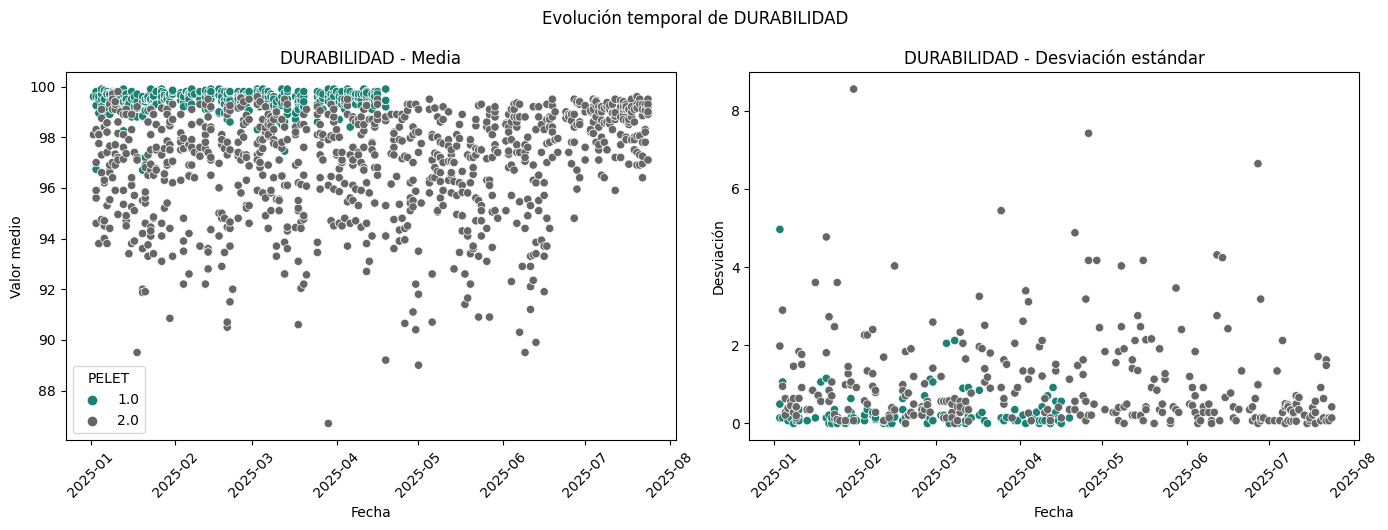

In [65]:
plot_metric_scatter_by_pelet(both, metric="DURABILIDAD", palette=palette_pel)